In [2]:
# Standard Library Imports
import os
import sys
from typing import List, Any, Callable, Union, Tuple, Optional
from importlib import reload
from functools import partial
from glob import glob
import cftime
import string
# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import cartopy.crs as ccrs
from matplotlib.ticker import MaxNLocator

# Custom Module Imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'zecmip_stabilisation'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_zecmip
import utils
import plotting_functions
import zec_calculation_functions
import sn_plotting
import my_stats
import signal_to_noise_calculations as sn_calc

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /jobfs/123168553.gadi-pbs/matplotlib-llaujhq2 because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
import matplotlib.patches as mpatches

In [4]:
constants.MODULE_DIR

'/home/563/ab2313/Documents/zecmip_stabilisation/src'

In [5]:
np.set_printoptions(precision=2, suppress=True, edgeitems=1)
xr.set_options(display_expand_data=False)

In [6]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'list_xarray'))
from listXarray import listXarray

In [7]:
# client.close()

In [8]:
# from dask.distributed import Client
# client = Client()
# client

# Opening Data

In [9]:
chunks = {'lat':-1, 'lon':-1, 'time':-1, 'ensemble':-1}

In [10]:
a1_raw_xrlist = open_zecmip.extract_experiment_into_xrlist('1000pgc', 'tas', chunks=chunks, logginglevel='ERROR'
                                                          ).to_dataarray('tas').sort_by_refkey()

In [11]:
pct_raw_xrlist = open_zecmip.extract_experiment_into_xrlist('1pct', 'tas', chunks=chunks).to_dataarray('tas').sort_by_refkey()

In [12]:
esmpi_raw_xrlist = (open_zecmip.extract_experiment_into_xrlist('picontrol', 'tas', chunks=chunks, logginglevel='INFO')
                    .to_dataarray('tas')
                    .isel(ensemble=0)
                    .squeeze('ensemble')
                    .sort_by_refkey()
                    .rename({'latitude':'lat', 'longitude': 'lon'}))

- ACCESS-ESM1-5
-      r1i1p1f1 - /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/v20210316/*.nc
- CanESM5
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p1f1/Amon/tas/gn/v20190429/*.nc
-      r1i1p2f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p2f1/Amon/tas/gn/v20190429/*.nc
- MIROC-ES2L
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/tas/gn/v20190823/*.nc
- UKESM1-0-LL
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/tas/gn/v20200828/*.nc
- MPI-ESM1-2-LR
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r1i1p1f1/Amon/tas/gn/v20190710/*.nc
-      r2i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r2i1p1f1/Amon/tas/gn/v20190815/*.nc
- GISS-E2-1-G-CC
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G-CC/piControl/r1i1p1f1/Amon/tas/gn/v2

In [13]:
# Match all the ensemble dimensions
pct_raw_xrlist = pct_raw_xrlist.cross_match_dim(a1_raw_xrlist, 'ensemble')
a1_raw_xrlist = a1_raw_xrlist.cross_match_dim(pct_raw_xrlist, 'ensemble')

In [14]:
# Only selecting one ensemble member for each model
a1_raw_xrlist = a1_raw_xrlist.isel(ensemble=0).chunk('auto')
pct_raw_xrlist = pct_raw_xrlist.isel(ensemble=0).chunk('auto')
esmpi_raw_xrlist = esmpi_raw_xrlist.isel(ensemble=0).chunk('auto')

In [15]:
# After the year 1000 all values appear to be 0
#esmpi_raw_xrlist['CanESM5'] = esmpi_raw_xrlist['CanESM5'].isel(time=slice(None,1000))

In [16]:
a1_raw_xrlist

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 1212, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'model': 1, 'time': 1800, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'model': 1, 'time': 1200, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 2400, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'time': 2160, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'model': 1, 'time': 2976, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'time': 2220, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'model': 1, 'time': 1200, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'model': 1, 'time': 3960, 'lat': 144, 'lon': 192})

In [17]:
esmpi_raw_xrlist['CanESM5']

<xarray.DataArray 'tas' (model: 1, time: 16800, lat: 64, lon: 128)> Size: 551MB
dask.array<chunksize=(1, 2400, 64, 128), meta=np.ndarray>
Coordinates:
  * time      (time) object 134kB 5201-01-16 12:00:00 ... 6600-12-16 12:00:00
  * lat       (lat) float64 512B -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon       (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * model     (model) <U7 28B 'CanESM5'
    ensemble  <U8 32B 'r1i1p1f1'
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        ST+273.16, CMIP_table_comment: near-surface (usually, 2 m...
    units:          K
    original_name:  ST
    history:        degctok 2019-04-30T17:18:16Z altered by CMOR: Treated sca...
    cell_methods:   area: time: mean
    cell_measures:  area: areacella

# Calculations

##  Data Processing and Mean Calculation

In [18]:
# Convert to celcius
a1_raw_xrlist = a1_raw_xrlist - 273.15
pct_raw_xrlist = pct_raw_xrlist - 273.15
esmpi_raw_xrlist = esmpi_raw_xrlist - 273.15

In [19]:
esmpi_regrid_xrlist = esmpi_raw_xrlist.chunk('auto').regrid('MPI-ESM1-2-LR', 'bilinear').set_refkeys('model')
pct_regrid_xrlist = pct_raw_xrlist.chunk('auto').regrid('MPI-ESM1-2-LR', 'bilinear').set_refkeys('model')
a1_regrid_xrlist = a1_raw_xrlist.chunk('auto').regrid('MPI-ESM1-2-LR', 'bilinear').set_refkeys('model')

In [20]:
# Making the data yearly
esmpi_xrlist = esmpi_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model').chunk('auto')
pct_xrlist = pct_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model').chunk('auto')
a1_xrlist = a1_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model').chunk('auto')

In [21]:
a1_xrlist

key_dim = model


Number of da/ds: 9
---------------
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'time': 185, 'lat': 96, 'lon': 192})
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 101, 'lat': 96, 'lon': 192})
CESM2          (dataArray): ({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
CanESM5        (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 200, 'lat': 96, 'lon': 192})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'time': 180, 'lat': 96, 'lon': 192})
MIROC-ES2L     (dataArray): ({'model': 1, 'time': 248, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
UKESM1-0-LL    (dataArray): ({'model': 1, 'time': 330, 'lat': 96, 'lon': 192})

In [22]:
# Subsetting to only first 150 years so all models have equal footing

# Reduce time so that the smalles time densions matches. This is at 101 years
a1_xrlist = a1_xrlist.isel(time=slice(None, 100))
a1_xrlist

key_dim = model


Number of da/ds: 9
---------------
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
CESM2          (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
CanESM5        (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
MIROC-ES2L     (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
UKESM1-0-LL    (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})

In [23]:
# The global weighted mean
pct_smean_xrlist = pct_xrlist.chunk('auto').apply(my_stats.space_mean)
a1_smean_xrlist = a1_xrlist.chunk('auto').apply(my_stats.space_mean)
esmpi_smean_xrlist = esmpi_xrlist.apply(my_stats.space_mean)

model
model
model


In [24]:
%%time
esmpi_smean_xrlist = esmpi_smean_xrlist.compute()
a1_smean_xrlist = a1_smean_xrlist.compute()
pct_smean_xrlist = pct_smean_xrlist.compute()

CPU times: user 4min 14s, sys: 56.1 s, total: 5min 10s
Wall time: 2min 14s


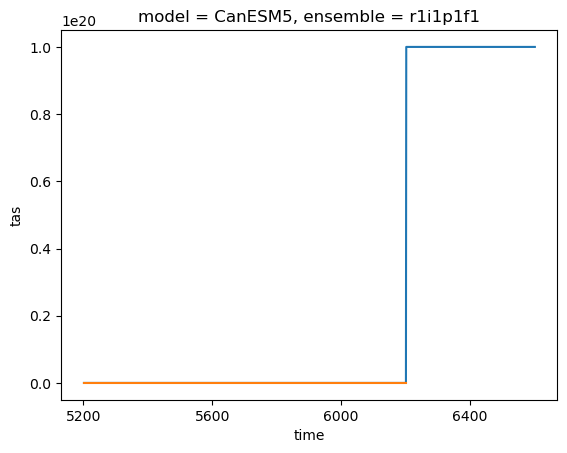

In [25]:
esmpi_smean_xrlist['CanESM5'].plot()
esmpi_smean_xrlist['CanESM5'].isel(time=slice(None, 1000)).plot()

In [26]:
esmpi_smean_xrlist['CanESM5'] = esmpi_smean_xrlist['CanESM5'].isel(time=slice(None, 1000))

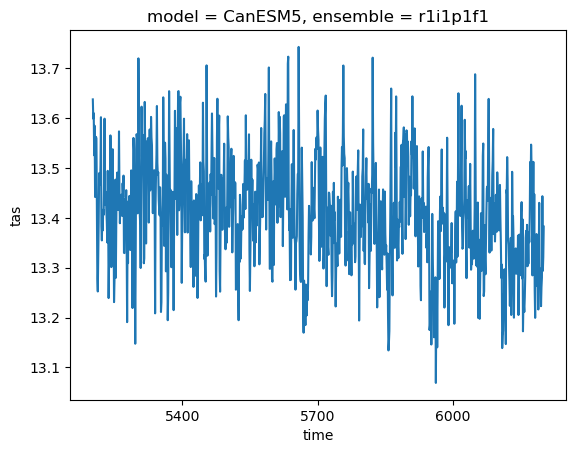

In [27]:
esmpi_smean_xrlist['CanESM5'].plot()

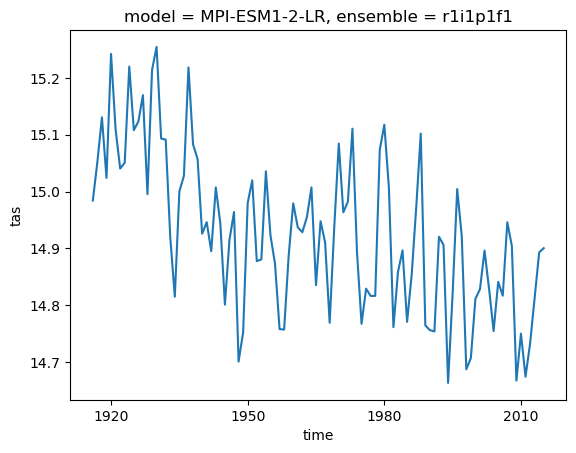

In [28]:
a1_smean_xrlist[0].plot()

In [29]:
# Calculate the values at the branching point
branch_point_mean_xrlist = listXarray([zec_calculation_functions.calculate_branch_average(
    pct_smean_xrlist[model], a1_smean_xrlist[model], logginglevel='INFO') for model in pct_smean_xrlist.refkeys]).set_refkeys('model')

- ['MPI-ESM1-2-LR'] - ['MPI-ESM1-2-LR']
- branch_start_time=cftime.DatetimeProlepticGregorian(1915, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=65
- 

- ['ACCESS-ESM1-5'] - ['ACCESS-ESM1-5']
- branch_start_time=cftime.DatetimeProlepticGregorian(168, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- ['CESM2'] - ['CESM2']
- branch_start_time=cftime.DatetimeNoLeap(68, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- ['CanESM5'] - ['CanESM5']
- branch_start_time=cftime.DatetimeNoLeap(1911, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=61
- 

- ['GFDL-ESM4'] - ['GFDL-ESM4']
- branch_start_time=cftime.DatetimeNoLeap(64, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=63
- 

- ['GISS-E2-1-G-CC'] - ['GISS-E2-1-G-CC']
- branch_start_time=cftime.DatetimeNoLeap(1920, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=70
- 

- ['MIROC-ES2L'] - ['MIROC-ES2L']
- branch_start_time=cftime.DatetimeGregorian(1913, 

In [30]:
# The amomaly time series from the branch point
a1_smean_anom_xrlist = (a1_smean_xrlist - branch_point_mean_xrlist).compute()

In [31]:
a1_smean_xrlist

key_dim = model


Number of da/ds: 9
---------------
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'time': 100})
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 100})
CESM2          (dataArray): ({'model': 1, 'time': 100})
CanESM5        (dataArray): ({'model': 1, 'time': 100})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 100})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'time': 100})
MIROC-ES2L     (dataArray): ({'model': 1, 'time': 100})
NorESM2-LM     (dataArray): ({'model': 1, 'time': 100})
UKESM1-0-LL    (dataArray): ({'model': 1, 'time': 100})

In [32]:
# All modles now have matching coordinates - can now be converted to xarray
# previosly a1 was a1_smean_anom_xrlist
a1_smean_anom_ds = a1_smean_anom_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model').drop('ensemble')
a1_smean_ds = a1_smean_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model').drop('ensemble')
pct_smean_ds = pct_smean_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model').drop('ensemble')
esmpi_smean_ds = esmpi_smean_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model').drop('ensemble')

model
model
model
model


In [33]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
zec25_ds = a1_smean_anom_ds.isel(time=slice(15, 35)).mean(dim='time')
zec50_ds = a1_smean_anom_ds.isel(time=slice(40, 60)).mean(dim='time')
zec50_ds

<xarray.DataArray 'tas' (model: 9)> Size: 72B
-0.2702 0.0113 -0.3096 -0.1017 -0.2054 -0.09008 -0.1086 -0.3344 0.2894
Coordinates:
  * model    (model) <U14 504B 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'

In [34]:
zec50_ds.to_pandas().sort_index().round(2)

model
ACCESS-ESM1-5     0.01
CESM2            -0.31
CanESM5          -0.10
GFDL-ESM4        -0.21
GISS-E2-1-G-CC   -0.09
MIROC-ES2L       -0.11
MPI-ESM1-2-LR    -0.27
NorESM2-LM       -0.33
UKESM1-0-LL       0.29
dtype: float64

In [35]:
a1_smean_anom_ds = a1_smean_anom_ds.dropna(dim='time')

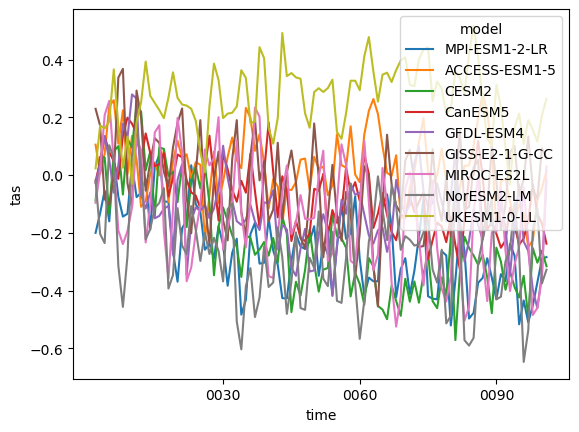

In [36]:
a1_smean_anom_ds.plot(hue='model');

## De-trending

In [37]:
# Detrend the data
a1_smean_anom_trendfit_ds = my_stats.trend_fit(a1_smean_anom_ds, method='polynomial', order=4)
a1_smean_anom_detrend_ds = a1_smean_anom_ds - a1_smean_anom_trendfit_ds

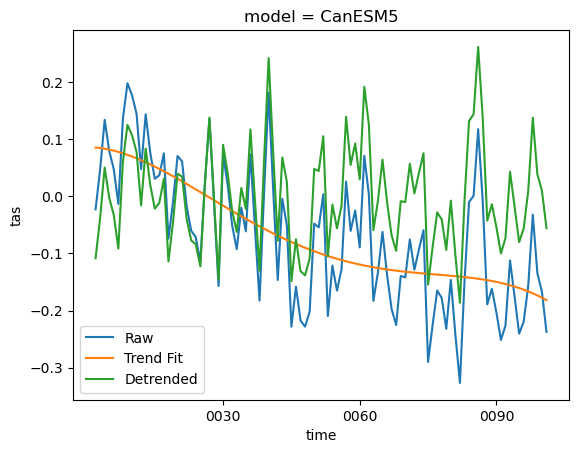

In [38]:
model = 'CanESM5'#'CESM2'
a1_smean_anom_ds.sel(model=model).plot(label='Raw')
a1_smean_anom_trendfit_ds.sel(model=model).plot(label='Trend Fit')
a1_smean_anom_detrend_ds.sel(model=model).plot(label='Detrended')
plt.legend()

## Single window checks S/N Ratio

In [39]:
signal_rolling_ds, noise_rolling_ds, sn_ratio_test_rolling = sn_calc.signal_to_noise_ratio(
    a1_smean_anom_ds, 30, detrended_data=a1_smean_anom_detrend_ds, 
    noise_type='rolling', logginglevel='INFO', return_all=True)

- Calculating the rolling signal with method gradient
- noise_type='rolling'
- Calculting the rolling noise


In [40]:
signal_satatic_ds, noise_static_ds ,sn_ratio_test_static = sn_calc.signal_to_noise_ratio(
    a1_smean_anom_ds, 30, detrended_data=a1_smean_anom_detrend_ds
    , noise_type='static', logginglevel='INFO', return_all=True)

- Calculating the rolling signal with method gradient
- noise_type='static'
- Calculting the static noise


In [41]:
sn_calc.rolling_noise(a1_smean_anom_detrend_ds, 30)

<xarray.DataArray 'noise' (window: 1, model: 9, time: 70)> Size: 5kB
0.1047 0.1007 0.09925 0.1101 0.1145 ... 0.09879 0.09891 0.09869 0.09785 0.09825
Coordinates:
  * model    (model) <U14 504B 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * time     (time) object 560B 0001-12-31 00:00:00 ... 0070-12-31 00:00:00
  * window   (window) int64 8B 30

In [42]:
sn_calc.static_noise(a1_smean_anom_detrend_ds)

<xarray.DataArray 'noise' (model: 9)> Size: 72B
0.1068 0.1074 0.09186 0.08833 0.1078 0.1367 0.1684 0.1539 0.09786
Coordinates:
  * model    (model) <U14 504B 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'

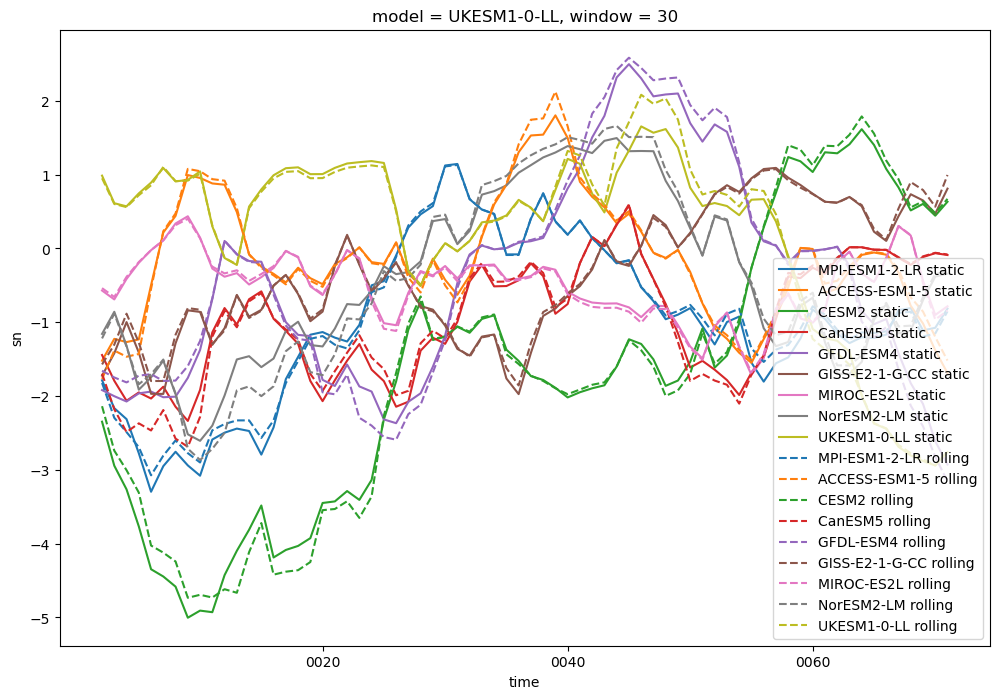

In [43]:
# Define a consistent color palette
models = sn_ratio_test_static.model.values
palette = sns.color_palette("tab10", n_colors=len(models))
color_dict = dict(zip(models, palette))

# Create the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the first dataset
for model in models:
    sn_ratio_test_static.sel(model=model).plot(ax=ax, color=color_dict[model], label=f"{model} static")

# Plot the second dataset
for model in models:
    sn_ratio_test_rolling.sel(model=model).plot(ax=ax, color=color_dict[model], linestyle='--', label=f"{model} rolling")

# Add legend
ax.legend()

## Multi-window S/N Ratio

In [44]:
# Params to use for both
SN_PARAMS = dict(return_all=True, center=True, return_control=True, logginglevel='ERROR')

In [45]:
# This is the length that all of the plots shoudl go to
# The end window is from the np.arange, and so goes to one before (so subtract one).
max_effective_length = len(a1_smean_anom_ds.time.values) - (constants.ZECMIP_MULTI_WINDOW_PARAMS['stop']-1)
max_effective_length

60

In [46]:
windows = np.arange(**constants.ZECMIP_MULTI_WINDOW_PARAMS)
windows

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

In [47]:
SN_RATIO_KWARGS = dict(parallel=True,logginglevel='ERROR')

In [48]:
reload(sn_calc)

<module 'signal_to_noise_calculations' from '/home/563/ab2313/Documents/zecmip_stabilisation/src/signal_to_noise_calculations.py'>

In [49]:
# # Calculate the S/R ratio for the A1 experiment. This noise should be the detrended data
sn_multi_static_da = sn_calc.signal_to_noise_ratio_multi_window(
    a1_smean_anom_ds,
    windows,
    detrended_data=a1_smean_anom_detrend_ds,
    noise_type='static',
    **SN_RATIO_KWARGS
)

sn_multi_static_da.name = 'signal_to_noise'

In [50]:
reload(sn_calc)

<module 'signal_to_noise_calculations' from '/home/563/ab2313/Documents/zecmip_stabilisation/src/signal_to_noise_calculations.py'>

In [51]:
# # Calculate the S/R ratio for the A1 experiment. This noise should be the detrended data
signal_multi_rolling_da = sn_calc.multi_window_func(
    sn_calc.rolling_signal, a1_smean_anom_ds, windows,
    **SN_RATIO_KWARGS
)

In [52]:
# # Calculate the S/R ratio for the A1 experiment. This noise should be the detrended data
noise_multi_rolling_da = sn_calc.multi_window_func(
    sn_calc.rolling_noise, a1_smean_anom_ds, windows,
    **SN_RATIO_KWARGS
)

In [53]:
# # Calculate the S/R ratio for the A1 experiment. This noise should be the detrended data
sn_multi_rolling_da = sn_calc.signal_to_noise_ratio_multi_window(
    a1_smean_anom_ds, windows,
    detrended_data=a1_smean_anom_detrend_ds,
    noise_type='rolling',
    **SN_RATIO_KWARGS
)

sn_multi_rolling_da.name = 'signal_to_noise'

In [54]:
sn_multi_static_control_ds = sn_calc.signal_to_noise_ratio_multi_window(
    esmpi_smean_ds, windows, noise_type='static', **SN_RATIO_KWARGS
)

sn_multi_static_control_ds.name = 'signal_to_noise'

In [55]:
sn_multi_rolling_control_ds = sn_calc.signal_to_noise_ratio_multi_window(
    esmpi_smean_ds, windows, noise_type='rolling', **SN_RATIO_KWARGS
)

sn_multi_rolling_control_ds.name = 'signal_to_noise'

In [56]:
# The bounds from the pi-controls
rolling_bounds = sn_calc.upper_and_lower_bounds(sn_multi_rolling_control_ds, 1, 99)
static_bounds = sn_calc.upper_and_lower_bounds(sn_multi_static_control_ds, 1, 99)

In [57]:
# Mergine togeth with the bounds (more of a legacy need)
# Drop nan here, or some windows can be longer than others
sn_multi_static_ds = xr.merge([sn_multi_static_da.to_dataset().dropna(dim='time'), static_bounds])
sn_multi_rolling_ds = xr.merge([sn_multi_rolling_da.to_dataset().dropna(dim='time'), rolling_bounds])

In [58]:
sn_multi_rolling_ds

<xarray.Dataset> Size: 140kB
Dimensions:          (model: 9, time: 60, window: 31)
Coordinates:
  * model            (model) <U14 504B 'MPI-ESM1-2-LR' ... 'UKESM1-0-LL'
  * time             (time) object 480B 0001-12-31 00:00:00 ... 0060-12-31 00...
  * window           (window) int64 248B 10 11 12 13 14 15 ... 35 36 37 38 39 40
Data variables:
    signal_to_noise  (window, model, time) float64 134kB 1.218 0.6431 ... -3.002
    lower_bound      (window, model) float64 2kB -2.95 -2.997 ... -2.227 -2.327
    upper_bound      (window, model) float64 2kB 2.975 2.981 ... 1.975 2.552

In [59]:
# # Number of models stable at each time step.
rolling_stability_levels_ds = sn_calc.get_increase_and_decreasing_stability_number(sn_multi_rolling_ds)
static_stability_levels_ds = sn_calc.get_increase_and_decreasing_stability_number(sn_multi_static_ds)

In [60]:
# Just the unstalgbe points - both xrlist and ds
above_or_below_kwargs = dict(main_var='signal_to_noise', greater_than_var='upper_bound', less_than_var='lower_bound')

unstable_rolling_ds = sn_multi_rolling_ds.utils.above_or_below(**above_or_below_kwargs)
unstable_static_ds = sn_multi_static_ds.utils.above_or_below(**above_or_below_kwargs)

In [61]:
# For each window get the number of years that are stable forn each point in time
decreasing_ds = xr.where(unstable_rolling_ds < 0, 1, 0)
increasing_ds = xr.where(unstable_rolling_ds > 0, 1, 0)

In [62]:
# THe stable year is an arg - need to turn these into year (starts from 0, so is
# essentially an arg)
unstable_static_ds['time'] = unstable_static_ds.time.dt.year.values
unstable_rolling_ds['time'] = unstable_rolling_ds.time.dt.year.values

## Get year of stabilisation

## Original

In [63]:
ufunc_year_stabilisation_kwargs = dict(
    input_core_dims=[['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    output_dtypes=[np.float]
)

In [64]:
# Get the year that stabilisation occurs
static_year_stable_ds_original = xr.apply_ufunc(
    sn_calc.find_stability_index,
    unstable_static_ds.signal_to_noise.squeeze(),
    unstable_static_ds.window,
    **ufunc_year_stabilisation_kwargs
)

In [65]:
# Get the year that stabilisation occurs
rolling_year_stable_ds_original  = xr.apply_ufunc(
    sn_calc.find_stability_index,
    unstable_rolling_ds.signal_to_noise.squeeze(),
    unstable_rolling_ds.window,
    **ufunc_year_stabilisation_kwargs
)

# De-stabilisatin Detection

In [66]:
windows = unstable_rolling_ds.window.values

In [134]:
reload(sn_calc)

<module 'signal_to_noise_calculations' from '/home/563/ab2313/Documents/zecmip_stabilisation/src/signal_to_noise_calculations.py'>

In [135]:
year_stable_and_unstable_static_ds = xr.apply_ufunc(
    calcuate_year_stable_and_unstable,
    unstable_static_ds.transpose(*['time', 'window', 'model']).signal_to_noise,
    input_core_dims=[['time', 'window']],
    output_core_dims=[['stability_index']],
    dask_gufunc_kwargs={'output_sizes': {'stability_index': 7}},
    vectorize=True,
    kwargs={'logginglevel':'ERROR'}
)
year_stable_and_unstable_static_ds=year_stable_and_unstable_static_ds.assign_coords(
    stability_index=[1, 2, 3, 4, 5, 6, 7])

year_stable_and_unstable_static_ds.attrs['Stability index'] ='Odd values mean stable, even mean unstable'

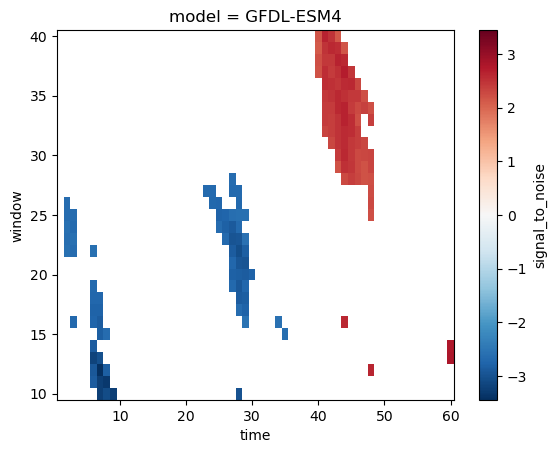

In [136]:
unstable_rolling_ds.isel(model=4).signal_to_noise.plot(y='window')

In [137]:
# year_stable_and_unstable_rolling_ds = xr.apply_ufunc(
#     ,
#     # unstable_rolling_ds.sel(model='GFDL-ESM4').transpose(*['time', 'window']).signal_to_noise,
#     unstable_rolling_ds.isel(model=1).transpose(*['time', 'window']).signal_to_noise,
#     input_core_dims=[['time', 'window']],
#     output_core_dims=[['stability_index']],
#     dask_gufunc_kwargs={'output_sizes': {'stability_index': 7}},
#     vectorize=True,
#     kwargs={'logginglevel':'ERROR'}
# )

In [158]:
reload(sn_calc)
year_stable_and_unstable_rolling_ds = xr.apply_ufunc(
    partial(sn_calc.calcuate_year_stable_and_unstable, windows=windows),
    # unstable_rolling_ds.sel(model='GFDL-ESM4').transpose(*['time', 'window']).signal_to_noise,
    unstable_rolling_ds.transpose(*['time', 'window', 'model']).signal_to_noise,
    input_core_dims=[['time', 'window']],
    output_core_dims=[['stability_index']],
    dask_gufunc_kwargs={'output_sizes': {'stability_index': 7}},
    vectorize=True,
    kwargs={'logginglevel':'ERROR'}
)
year_stable_and_unstable_rolling_ds=year_stable_and_unstable_rolling_ds.assign_coords(
    stability_index=[1, 2, 3, 4, 5, 6, 7])

year_stable_and_unstable_rolling_ds.attrs['Stability index'] ='Odd values mean stable, even mean unstable'

In [159]:
# reload(sn_calc)
# calcuate_year_stable_and_unstable = partial(sn_calc.calcuate_year_stable_and_unstable, windows=windows)

# td = xr.apply_ufunc(
#     calcuate_year_stable_and_unstable,
#     unstable_rolling_ds.sel(model='GFDL-ESM4').transpose(*['time', 'window']).signal_to_noise,
#     # unstable_rolling_ds.transpose(*['time', 'window', 'model']).signal_to_noise,
#     input_core_dims=[['time', 'window']],
#     output_core_dims=[['stability_index']],
#     dask_gufunc_kwargs={'output_sizes': {'stability_index': 7}},
#     vectorize=True,
#     kwargs={'logginglevel':'DEBUG'}
# )
# # year_stable_and_unstable_rolling_ds=year_stable_and_unstable_rolling_ds.assign_coords(
# #     stability_index=[1, 2, 3, 4, 5, 6, 7])

# # year_stable_and_unstable_rolling_ds.attrs['Stability index'] ='Odd values mean stable, even mean unstable'

In [160]:
year_stable_and_unstable_rolling_ds

<xarray.DataArray 'signal_to_noise' (model: 9, stability_index: 7)> Size: 504B
16.0 nan nan nan nan nan nan 0.0 nan nan ... nan nan 0.0 nan nan nan nan nan nan
Coordinates:
  * model            (model) <U14 504B 'MPI-ESM1-2-LR' ... 'UKESM1-0-LL'
  * stability_index  (stability_index) int64 56B 1 2 3 4 5 6 7
Attributes:
    Stability index:  Odd values mean stable, even mean unstable

In [161]:
year_stable_and_unstable_rolling_ds.sel(stability_index=[1,3,5]).max(dim='stability_index')

<xarray.DataArray 'signal_to_noise' (model: 9)> Size: 72B
16.0 0.0 36.0 13.0 50.0 43.0 50.0 12.0 0.0
Coordinates:
  * model    (model) <U14 504B 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'

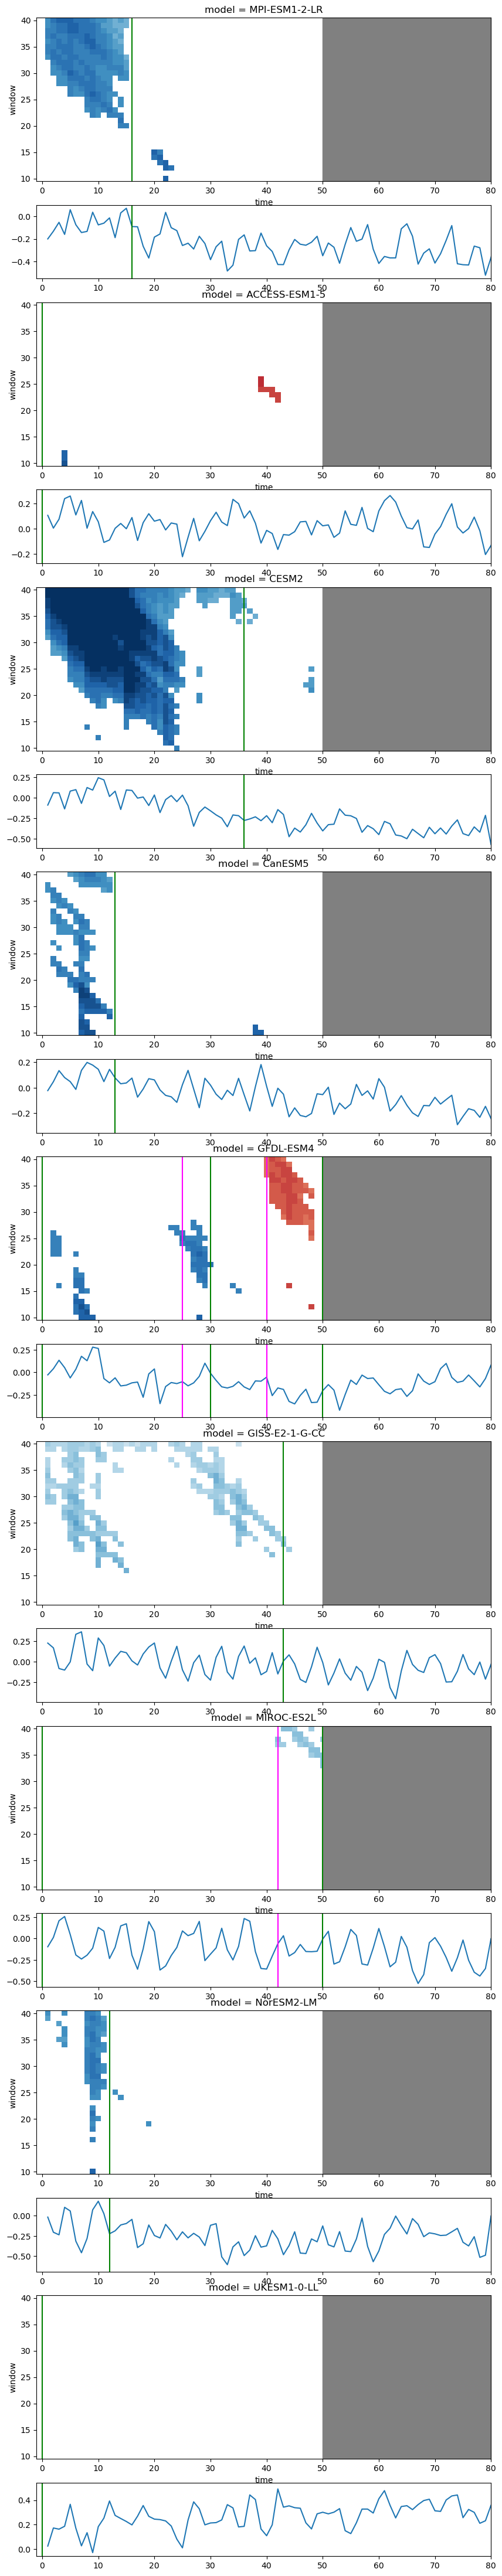

In [162]:
fig = plt.figure(figsize=(10, 45*1.25))
gs = gridspec.GridSpec(18,1, height_ratios=[1, 0.45]*9)
axes = [fig.add_subplot(gs[i]) for i in range(18)]

colors = ['green', 'magenta']
for mnum, num in enumerate(np.arange(0, 18, 2)):
    ax = axes[num]
    ax2 = axes[num+1]
    
    unstable_rolling_ds.sel(model=models[mnum]).signal_to_noise.plot(
        y='window', ax=ax, cmap='RdBu_r', levels=np.arange(-4, 4.25, .25), add_colorbar=False)

    
    a1_model_ds = a1_smean_anom_ds.sel(model=models[mnum])
    ax2.plot(a1_model_ds.time.dt.year.values, a1_model_ds.values)
    for num,year in enumerate(year_stable_and_unstable_rolling_ds.sel(model=models[mnum]).values):
        ax.axvline(year, c=colors[num%2])
        ax2.axvline(year, c=colors[num%2])

    ax.axvspan(50, 80, color='grey')
    ax.set_xlim(-1,80)
    ax2.set_xlim(-1,80)

In [ ]:
fig = plt.figure(figsize=(10, 45*1.25))
gs = gridspec.GridSpec(18,1, height_ratios=[1, 0.45]*9)
axes = [fig.add_subplot(gs[i]) for i in range(18)]

colors = ['green', 'magenta']
for mnum, num in enumerate(np.arange(0, 18, 2)):
    ax = axes[num]
    ax2 = axes[num+1]
    
    unstable_static_ds.sel(model=models[mnum]).signal_to_noise.plot(
        y='window', ax=ax, cmap='RdBu_r', add_colorbar=False)

    a1_model_ds = a1_smean_anom_ds.sel(model=models[mnum])
    ax2.plot(a1_model_ds.time.dt.year.values, a1_model_ds.values)
    for num,year in enumerate(year_stable_and_unstable_static_ds.sel(model=models[mnum]).values):
        ax.axvline(year, c=colors[num%2])
        ax2.axvline(year, c=colors[num%2])

    ax.axvspan(50, 80, color='grey')
    ax.set_xlim(0,80)
    ax2.set_xlim(0,80)

## Processing

In [75]:
static_year_stable_ds = year_stable_and_unstable_static_ds.sel(stability_index=1) #total_stable_year_da_static
rolling_year_stable_ds = year_stable_and_unstable_rolling_ds.sel(stability_index=1) #total_stable_year_da_rolling

In [76]:
static_year_stable_ds=static_year_stable_ds.to_dataset(name='time')
rolling_year_stable_ds=rolling_year_stable_ds.to_dataset(name='time')

In [77]:
rolling_year_stable_ds

<xarray.Dataset> Size: 584B
Dimensions:          (model: 9)
Coordinates:
  * model            (model) <U14 504B 'MPI-ESM1-2-LR' ... 'UKESM1-0-LL'
    stability_index  int64 8B 1
Data variables:
    time             (model) float64 72B 16.0 0.0 36.0 13.0 ... 0.0 12.0 0.0

# Tabulated

In [270]:
# exact_year_stable = year_stable_and_unstable_rolling_ds

# #rolling_year_stable_ds.time#rolling_year_stable_ds.max(dim='window').time
# exact_year_stable#.plot()

In [79]:
# to_concat = []
# for window in rolling_year_stable_ds.window.values:
#     window_ds = rolling_year_stable_ds.sel(window=window)
#     window_ds_pw = window_ds.copy(deep=True) + window
#     window_ds_pw = xr.where(window_ds==0, 0, window_ds_pw)
#     to_concat.append(window_ds_pw)
# rolling_year_stable_ds_plus_window = xr.concat(to_concat, dim='window')

In [359]:
year_stable_and_unstable_rolling_ds.stability_index.values[::2]

array([1, 3, 5, 7])

In [372]:
year_of_stabilisation_dict = {}
for model in year_stable_and_unstable_rolling_ds.model.values:
    model_dict = {}
    zec50_val = zec50_ds.sel(model=model).values.item()
    model_dict['zec50'] = zec50_val
    year_vals = year_stable_and_unstable_rolling_ds.sel(model=model).values
    for i in range(len(year_vals)):
        # print(i)
        yeari = year_vals[i]
        if np.isnan(yeari):
            avtemp = np.nan
            break
        else:
            if i+1 == len(year_stable_and_unstable_rolling_ds.stability_index.values):
                length=20
            else: 
                length = np.nanmin([20, year_vals[i+1]])
            yeari = int(yeari)
            length = int(length)
            # print(yeari, length)
            avtemp = (a1_smean_anom_ds.sel(model=model)
                      .isel(time=slice(int(yeari), int(yeari)+length))
                      .mean(dim='time').values.round(2).item())
            # print(avtemp)

        if i%2:
            label = 'unstable'
        else:
            label = 'stable'
        
        model_dict[f'{label}_{i+1}_year'] = yeari
        model_dict[f'{label}_{i+1}_avtemp'] = avtemp
        model_dict['zec50-final'] = np.round(zec50_val - avtemp, 2)
        model_dict['final_temp'] = avtemp
        model_dict['final_year_stable'] = (year_stable_and_unstable_rolling_ds
         .sel(stability_index=year_stable_and_unstable_rolling_ds.stability_index.values[::2], model=model)
         .max(dim='stability_index')).values#.item()

    # model_dict[model] =  

    year_of_stabilisation_dict[model] =  model_dict
year_of_stabilisation_df = pd.DataFrame(year_of_stabilisation_dict).transpose()

year_of_stabilisation_df = year_of_stabilisation_df.dropna(axis=1, how='all')

order_start = ['zec50', 'final_temp', 'zec50-final', 'final_year_stable']

year_of_stabilisation_df = year_of_stabilisation_df[order_start + [i for i in year_of_stabilisation_df if i not in order_start]]
year_of_stabilisation_df = year_of_stabilisation_df.round(2)

In [373]:
year_of_stabilisation_df

zec50 final_temp zec50-final final_year_stable  \
MPI-ESM1-2-LR  -0.270157      -0.23       -0.04              16.0   
ACCESS-ESM1-5   0.011302       0.06       -0.05               0.0   
CESM2          -0.309638      -0.28       -0.03              36.0   
CanESM5         -0.10173      -0.01       -0.09              13.0   
GFDL-ESM4       -0.20539      -0.16       -0.05              50.0   
GISS-E2-1-G-CC -0.090083      -0.13        0.04              43.0   
MIROC-ES2L     -0.108559      -0.16        0.05              50.0   
NorESM2-LM      -0.33444      -0.22       -0.11              12.0   
UKESM1-0-LL     0.289383       0.21        0.08               0.0   

               stable_1_year stable_1_avtemp unstable_2_year  \
MPI-ESM1-2-LR             16           -0.23             NaN   
ACCESS-ESM1-5              0            0.06             NaN   
CESM2                     36           -0.28             NaN   
CanESM5                   13           -0.01             NaN   
GFDL-ESM4                  0             0.0              25   
GISS-E2-1-G-CC            43           -0.13             NaN   
MIROC-ES2L                 0           -0.03              42   
NorESM2-LM                12           -0.22             NaN   
UKESM1-0-LL                0            0.21             NaN   

               unstable_2_avtemp stable_3_year stable_3_avtemp  \
MPI-ESM1-2-LR                NaN           NaN             NaN   
ACCESS-ESM1-5                NaN           NaN             NaN   
CESM2                        NaN           NaN             NaN   
CanESM5                      NaN           NaN             NaN   
GFDL-ESM4                  -0.14            30           -0.19   
GISS-E2-1-G-CC               NaN           NaN             NaN   
MIROC-ES2L                 -0.12            50           -0.16   
NorESM2-LM                   NaN           NaN             NaN   
UKESM1-0-LL                  NaN           NaN             NaN   

               unstable_4_year unstable_4_avtemp stable_5_year stable_5_avtemp  
MPI-ESM1-2-LR              NaN               NaN           NaN             NaN  
ACCESS-ESM1-5              NaN               NaN           NaN             NaN  
CESM2                      NaN               NaN           NaN             NaN  
CanESM5                    NaN               NaN           NaN             NaN  
GFDL-ESM4                   40             -0.21            50           -0.16  
GISS-E2-1-G-CC             NaN               NaN           NaN             NaN  
MIROC-ES2L                 NaN               NaN           NaN             NaN  
NorESM2-LM                 NaN               NaN           NaN             NaN  
UKESM1-0-LL                NaN               NaN           NaN             NaN

In [314]:
# year_of_stabilisation_dict = {}
# for model in exact_year_stable.model.values:
#     year = exact_year_stable.sel(model=model).values.item()
#     # window_ds = rolling_year_stable_ds.sel(model=model)
#     # window_val = window_ds.where(window_ds==year, drop=True).window.values[0]
#     avtemp_at_stabilisation = a1_smean_anom_ds.sel(model=model).isel(time=slice(int(year), int(year)+20)).mean(dim='time').values.round(2).item()
#     #temp_at_stabilisation = a1_smean_anom_ds.sel(model=model).isel(time=int(year)).values.item()
#     zec50_val = zec50_ds.sel(model=model).values.item()
#     year_of_stabilisation_dict[model] = {'year':year, #'temp':temp_at_stabilisation, 
#                                          'av_temp':avtemp_at_stabilisation, 'zec50': zec50_val} # 'window': window_val

In [315]:
# year_of_stabilisation_df = pd.DataFrame(year_of_stabilisation_dict).transpose().sort_index()

In [316]:
# year_of_stabilisation_df['diff'] = year_of_stabilisation_df['zec50'] - year_of_stabilisation_df['av_temp']

In [317]:
# year_of_stabilisation_df

In [376]:
print(year_of_stabilisation_df[['final_year_stable', 'final_temp']])

               final_year_stable final_temp
MPI-ESM1-2-LR               16.0      -0.23
ACCESS-ESM1-5                0.0       0.06
CESM2                       36.0      -0.28
CanESM5                     13.0      -0.01
GFDL-ESM4                   50.0      -0.16
GISS-E2-1-G-CC              43.0      -0.13
MIROC-ES2L                  50.0      -0.16
NorESM2-LM                  12.0      -0.22
UKESM1-0-LL                  0.0       0.21


In [377]:
# print(year_of_stabilisation_df[['year', 'av_temp']])

In [378]:
cooling_models = ['MPI-ESM1-2-LR', 'CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC', 'NorESM2-LM']

In [379]:
year_of_stabilisation_df.loc[cooling_models].mean(axis=0)

zec50                -0.218573
final_temp           -0.171667
zec50-final          -0.046667
final_year_stable    28.333333
stable_1_year             20.0
stable_1_avtemp         -0.145
unstable_2_year           25.0
unstable_2_avtemp        -0.14
stable_3_year             30.0
stable_3_avtemp          -0.19
unstable_4_year           40.0
unstable_4_avtemp        -0.21
stable_5_year             50.0
stable_5_avtemp          -0.16
dtype: object

In [380]:
year_of_stabilisation_df.mean(axis=0)

zec50                -0.124368
final_temp           -0.102222
zec50-final          -0.022222
final_year_stable    24.444444
stable_1_year        13.333333
stable_1_avtemp          -0.07
unstable_2_year           33.5
unstable_2_avtemp        -0.13
stable_3_year             40.0
stable_3_avtemp         -0.175
unstable_4_year           40.0
unstable_4_avtemp        -0.21
stable_5_year             50.0
stable_5_avtemp          -0.16
dtype: object

# Quick Verifications

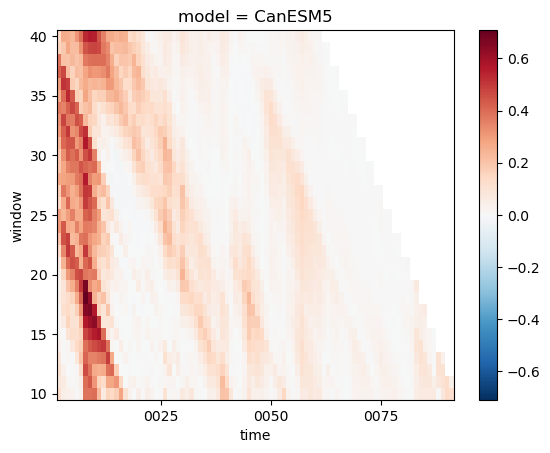

In [89]:
((signal_multi_rolling_da/noise_multi_rolling_da).isel(model=3)-sn_multi_rolling_da.isel(model=3)).plot()

In [90]:
rolling_year_stable_ds

<xarray.Dataset> Size: 584B
Dimensions:          (model: 9)
Coordinates:
  * model            (model) <U14 504B 'MPI-ESM1-2-LR' ... 'UKESM1-0-LL'
    stability_index  int64 8B 1
Data variables:
    time             (model) float64 72B 16.0 0.0 36.0 13.0 ... 0.0 12.0 0.0

In [91]:
rolling_year_stable_ds.time.isel(model=0).values.item()

16.0

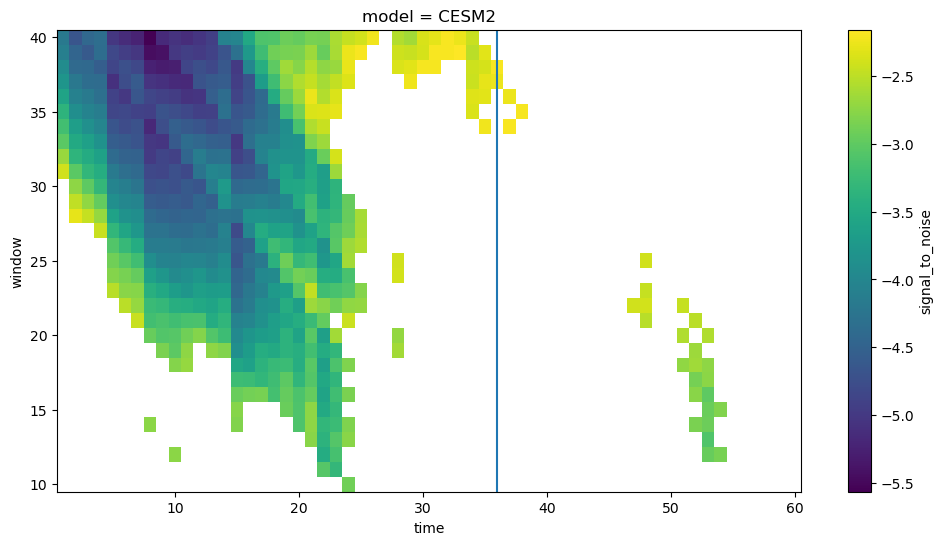

In [92]:
imodel=2
fig, ax = plt.subplots(1, 1,figsize=(12, 6))
unstable_rolling_ds.isel(model=imodel).signal_to_noise.plot(y='window', ax=ax)
# rolling_year_stable_ds.time.isel(model=imodel).plot(y='window', marker='o', color='red')
ax.axvline(rolling_year_stable_ds.time.isel(model=imodel).values.item())

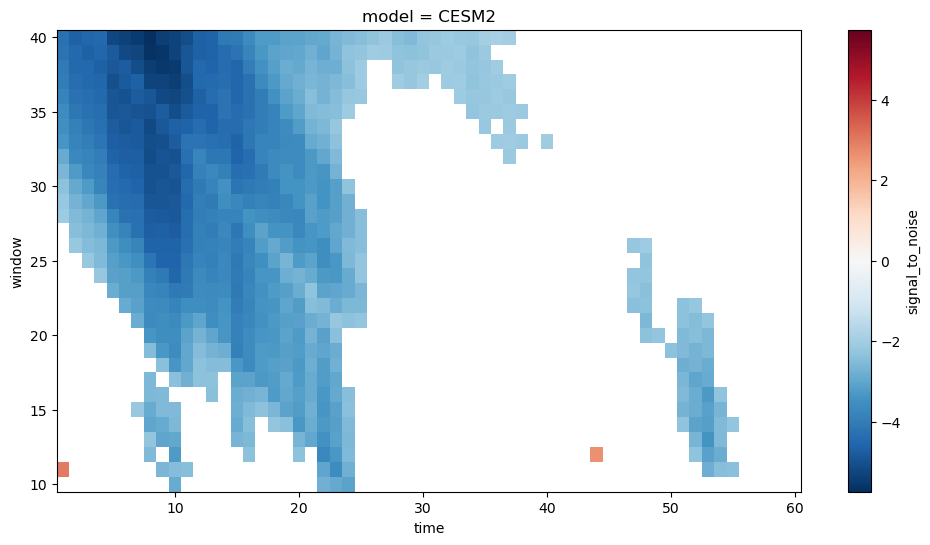

In [93]:
fig = plt.figure(figsize=(12, 6))
unstable_static_ds.isel(model=imodel).signal_to_noise.plot(y='window')
# static_year_stable_ds.time.isel(model=imodel).plot(y='window', marker='o', color='red')

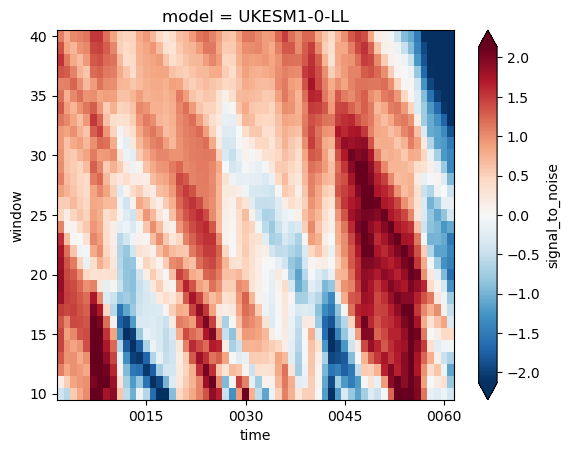

In [94]:
sn_multi_rolling_ds.sel(model='UKESM1-0-LL').signal_to_noise.plot(robust=True)

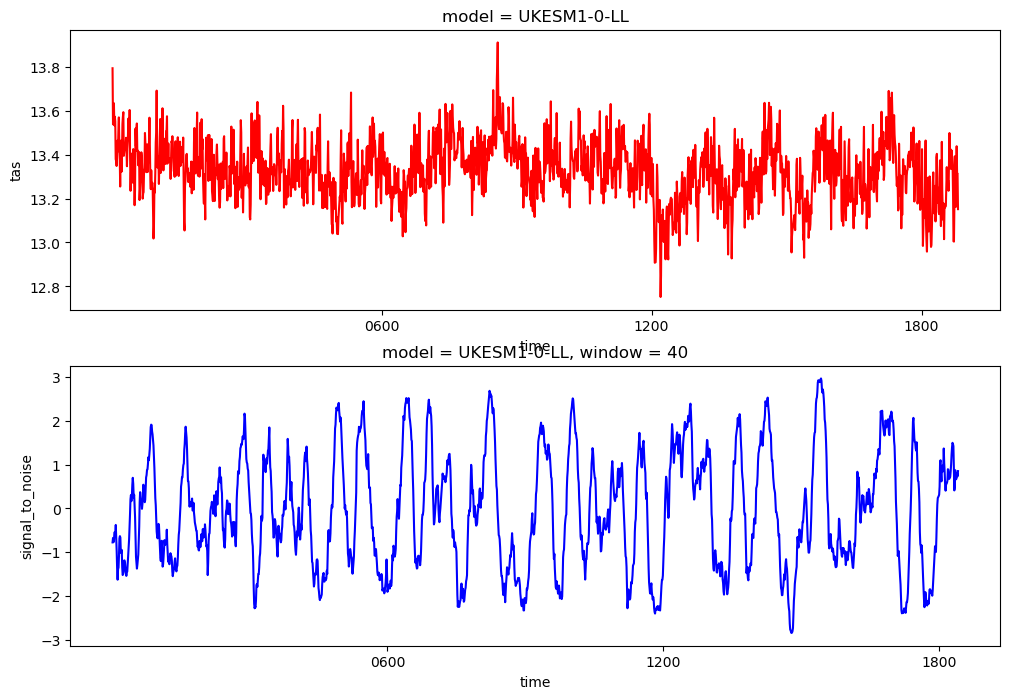

In [95]:
fig, (ax, ax2) = plt.subplots(2, 1,figsize=(12, 8))
# ax2 = ax.twinx()
esmpi_smean_ds.sel(model='UKESM1-0-LL').plot(ax=ax, color='red')
sn_multi_rolling_control_ds.sel(model='UKESM1-0-LL', window=40).plot(ax=ax2, color='blue')

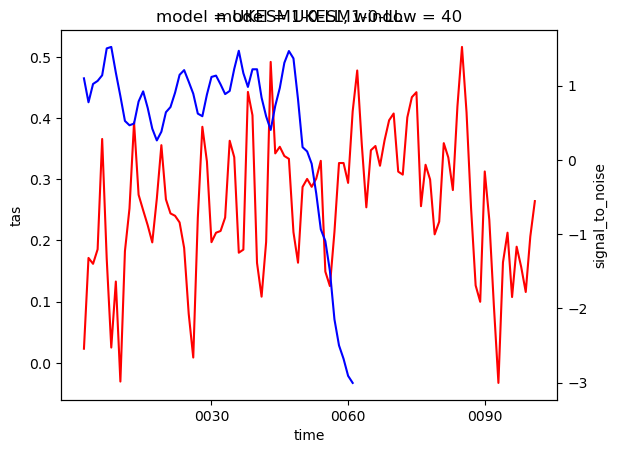

In [96]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
a1_smean_anom_ds.sel(model='UKESM1-0-LL').plot(ax=ax, color='red')
sn_multi_rolling_ds.signal_to_noise.sel(model='UKESM1-0-LL', window=40).plot(ax=ax2, color='blue')

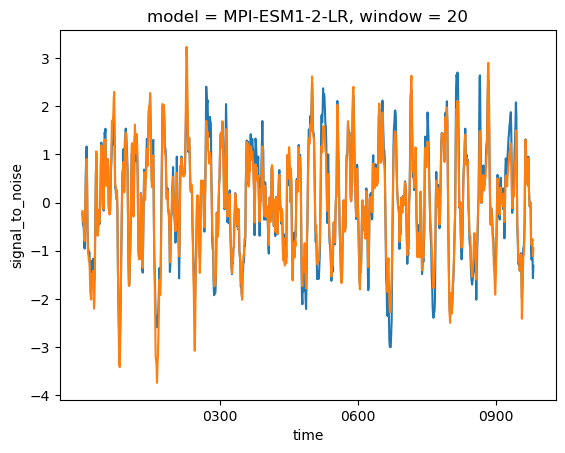

In [97]:
sn_multi_rolling_control_ds.isel(model=0, window=10).plot()
sn_multi_static_control_ds.isel(model=0, window=10).plot()

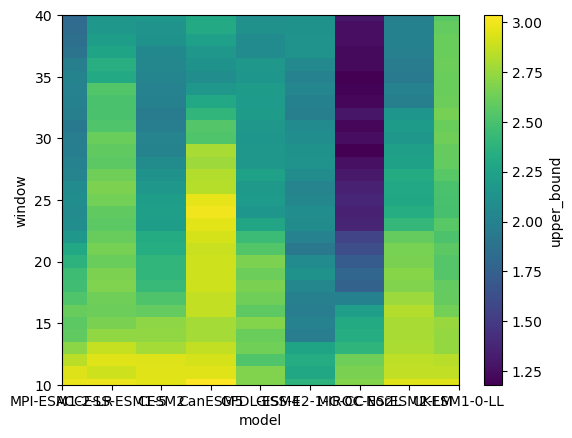

In [98]:
rolling_bounds.upper_bound.plot()

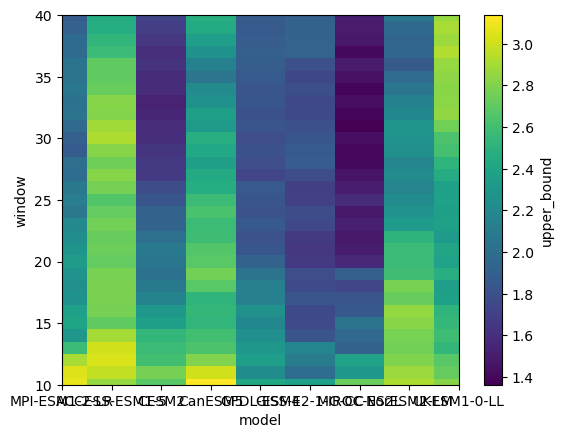

In [99]:
static_bounds.upper_bound.plot()

# Plots

## Set-up

In [100]:
units =  r'$^{\circ}C$'

In [101]:
def format_null_axis(ax):
    '''
    Axis that doesn't have any spines, or y tick labels or locaionts
    '''
    [ax.spines[sp].set_visible(False) for sp in ['top', 'left', 'right']]
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_title('')
    ax.set_ylabel('')

In [102]:
#### Note, this dictionary has also been put into constants as ZECMIP_MODEL_COLORS

# Create a list of models and their corresponding values
model_values = [(model, zec50_ds.sel(model=model).values.round(3)) for model in zec50_ds.model.values]

# Separate negative and positive values
negative_values = [(model, value) for model, value in model_values if value < 0]
positive_values = [(model, value) for model, value in model_values if value > 0]

# Sort the values by their absolute magnitude
negative_values.sort(key=lambda x: abs(x[1]))
positive_values.sort(key=lambda x: abs(x[1]))

# Create a colormap for negative values (BuPu_r) and positive values (OrRd)
# For the Blues we want to remove the three lower values there are too hard to see.  For the reds, just make sure it
# isn't the lower values. 
cut1 = 2
negative_colors = blue_colors = [
    '#add8e6',  # Light Blue
    '#87ceeb',  # Sky Blue
    '#6495ed',  # Cornflower Blue
    '#4169e1',  # Royal Blue
    '#1e90ff',  # Dodger Blue
    '#0000cd',  # Medium Blue
    '#00008b'   # Dark Blue
]
negative_line_styles = [
    '-',                # Solid
    '--',               # Dashed
    '-.',               # Dash-dot
    ':',                # Dotted
    '-',       # More frequent dashes, shorter space
    (0, (1, 1)),        # Densely dotted
    (0, (5, 1, 1, 1)),  # Dash, dot, dot, dot
]


#['#add8e6', '#87cefa', '#6495ed', '#4169e1', '#0000ff']#plt.cm.get_cmap('BuPu_r', len(negative_values)+cut1)(np.arange(len(negative_values)+cut1))[:-cut1]
positive_colors = plt.cm.get_cmap('OrRd', len(positive_values)+4)(np.arange(len(positive_values)+4))[::2][-2:]

# Create dictionaries for negative and positive values with color information
negative_zec50 = {model: {'value': value, 'color': color, 'linestyle':linestyle} for (model, value), color, linestyle in zip(negative_values, negative_colors, negative_line_styles)}
positive_zec50 = {model: {'value': value, 'color': color} for (model, value), color in zip(positive_values, positive_colors)}

# Combine the dictionaries into the final zec50_dict
zec50_dict = {**negative_zec50, **positive_zec50}
zec50_dict

{'GISS-E2-1-G-CC': {'value': -0.09, 'color': '#add8e6', 'linestyle': '-'},
 'CanESM5': {'value': -0.102, 'color': '#87ceeb', 'linestyle': '--'},
 'MIROC-ES2L': {'value': -0.109, 'color': '#6495ed', 'linestyle': '-.'},
 'GFDL-ESM4': {'value': -0.205, 'color': '#4169e1', 'linestyle': ':'},
 'MPI-ESM1-2-LR': {'value': -0.27, 'color': '#1e90ff', 'linestyle': '-'},
 'CESM2': {'value': -0.31, 'color': '#0000cd', 'linestyle': (0, (1, 1))},
 'NorESM2-LM': {'value': -0.334,
  'color': '#00008b',
  'linestyle': (0, (5, 1, 1, 1))},
 'ACCESS-ESM1-5': {'value': 0.011, 'color': array([0.99, 0.7 , 0.48, 1.  ])},
 'UKESM1-0-LL': {'value': 0.289, 'color': array([0.79, 0.11, 0.07, 1.  ])}}

In [103]:
stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=False, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

In [425]:
models = np.sort(a1_smean_anom_ds.model.values)
models

array(['ACCESS-ESM1-5', 'CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC',
       'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL'],
      dtype='<U14')

## Figure 1 (Stability and each window)

In [104]:
line_colors = ['green', 'magenta']

In [ ]:
stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=False, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

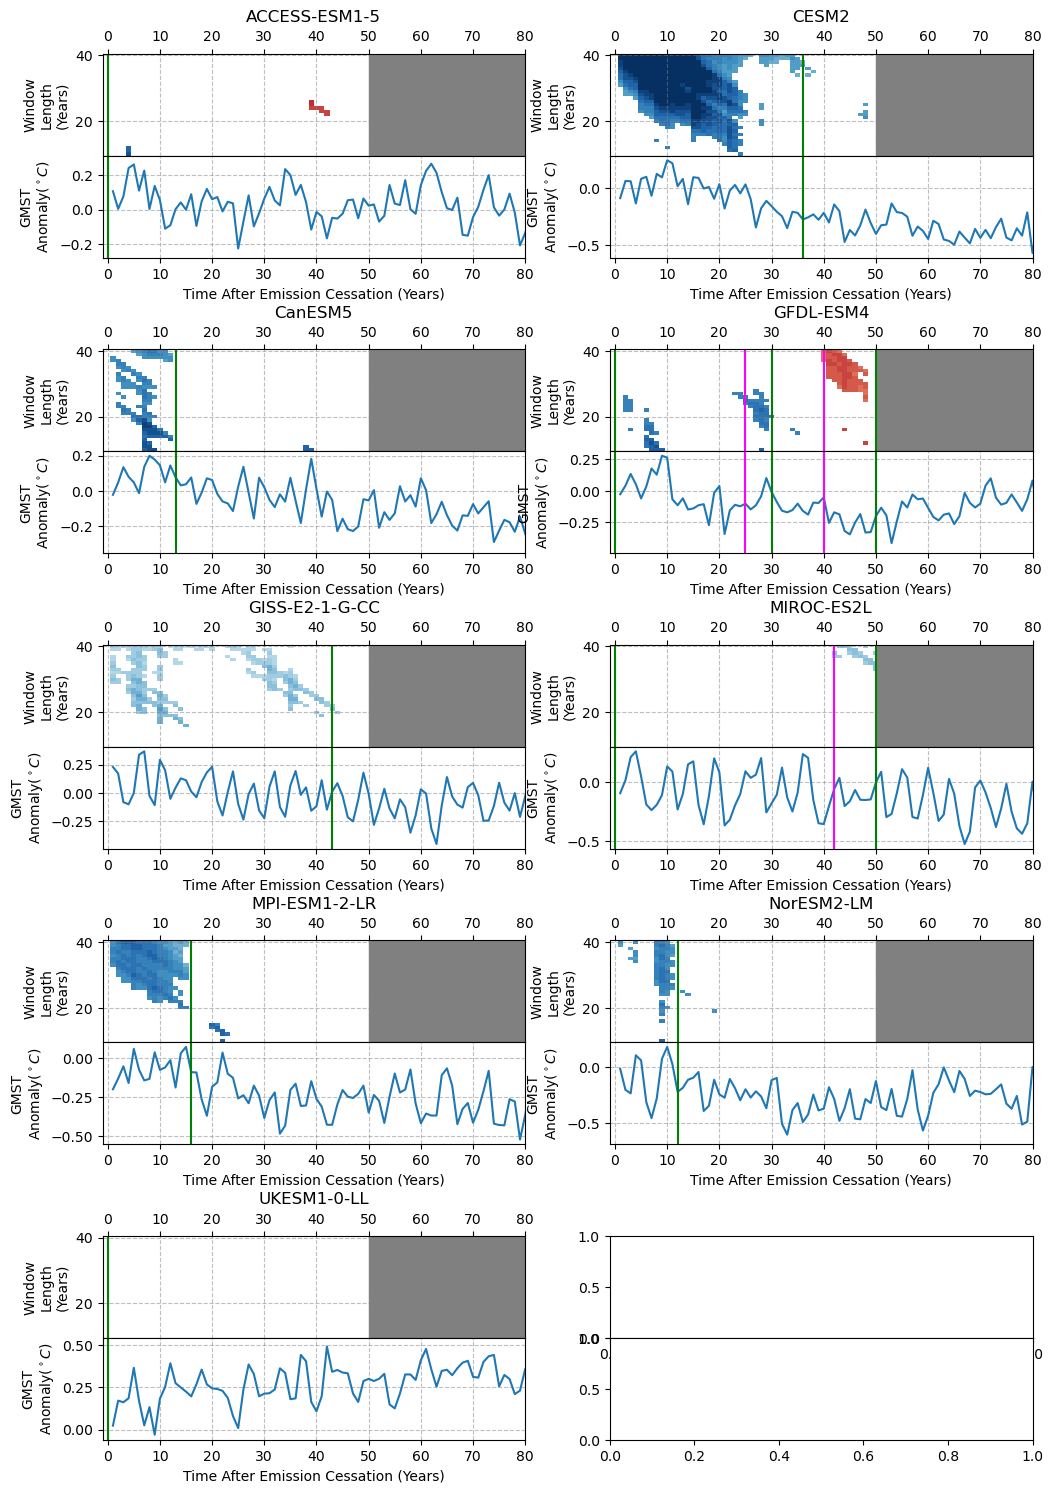

In [443]:
fig = plt.figure(figsize=(12, 18))
outer_gs = gridspec.GridSpec(5, 2, hspace=0.45, wspace=0.2)

# Lists to store axes
upper_axes = []
lower_axes = []

# Loop through the grid positions
for i in range(5):
    for j in range(2):  # Loop over the two columns
        # Create a GridSpec for the inner plots (1 large and 1 small)
        inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i, j], hspace=0)
        
        # Large plot (upper plot)
        upper_ax = fig.add_subplot(inner_gs[0])
        upper_axes.append(upper_ax)
        
        # Small plot (lower plot)
        lower_ax = fig.add_subplot(inner_gs[1])
        lower_axes.append(lower_ax)

for num, model in enumerate(models):
    ax = upper_axes[num]
    ax_lower = lower_axes[num]

    unstable_rolling_ds.sel(model=model).signal_to_noise.plot(
        y='window', ax=ax, cmap='RdBu_r', levels=np.arange(-4, 4.25, .25), add_colorbar=False)

    
    a1_model_ds = a1_smean_anom_ds.sel(model=model)
    ax_lower.plot(a1_model_ds.time.dt.year.values, a1_model_ds.values)
    for num,year in enumerate(year_stable_and_unstable_rolling_ds.sel(model=model).values):
        ax.axvline(year, c=colors[num%2])
        ax_lower.axvline(year, c=colors[num%2])

    ax.axvspan(50, 80, color='grey')
    ax.set_xlim(-1,80)
    ax_lower.set_xlim(-1,80)
    ax.set_title(model)

    ax.grid(True, linestyle='--', alpha=0.5, color='grey')
    ax_lower.grid(True, linestyle='--', alpha=0.5, color='grey')

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xlabel('')
    ax_lower.set_xlabel('Time After Emission Cessation (Years)')
    ax.set_ylabel('Window\nLength\n(Years)')
    ax_lower.set_ylabel('GMST\nAnomaly'+r'($^\circ C$)')
    if num%2:
        ax.tick_params(axis='y', labelleft=False, labelright=True, which='both', direction='inout', length=6)    
        ax.yaxis.set_ticks_position('right')
        ax.spines['right'].set_position(('outward', 0))
        ax.yaxis.set_label_position('right')

        ax_lower.tick_params(axis='y', labelleft=False, labelright=True, which='both', direction='inout', length=6)
        ax_lower.yaxis.set_ticks_position('right')
        ax_lower.spines['right'].set_position(('outward', 0))
        ax_lower.yaxis.set_label_position('right')

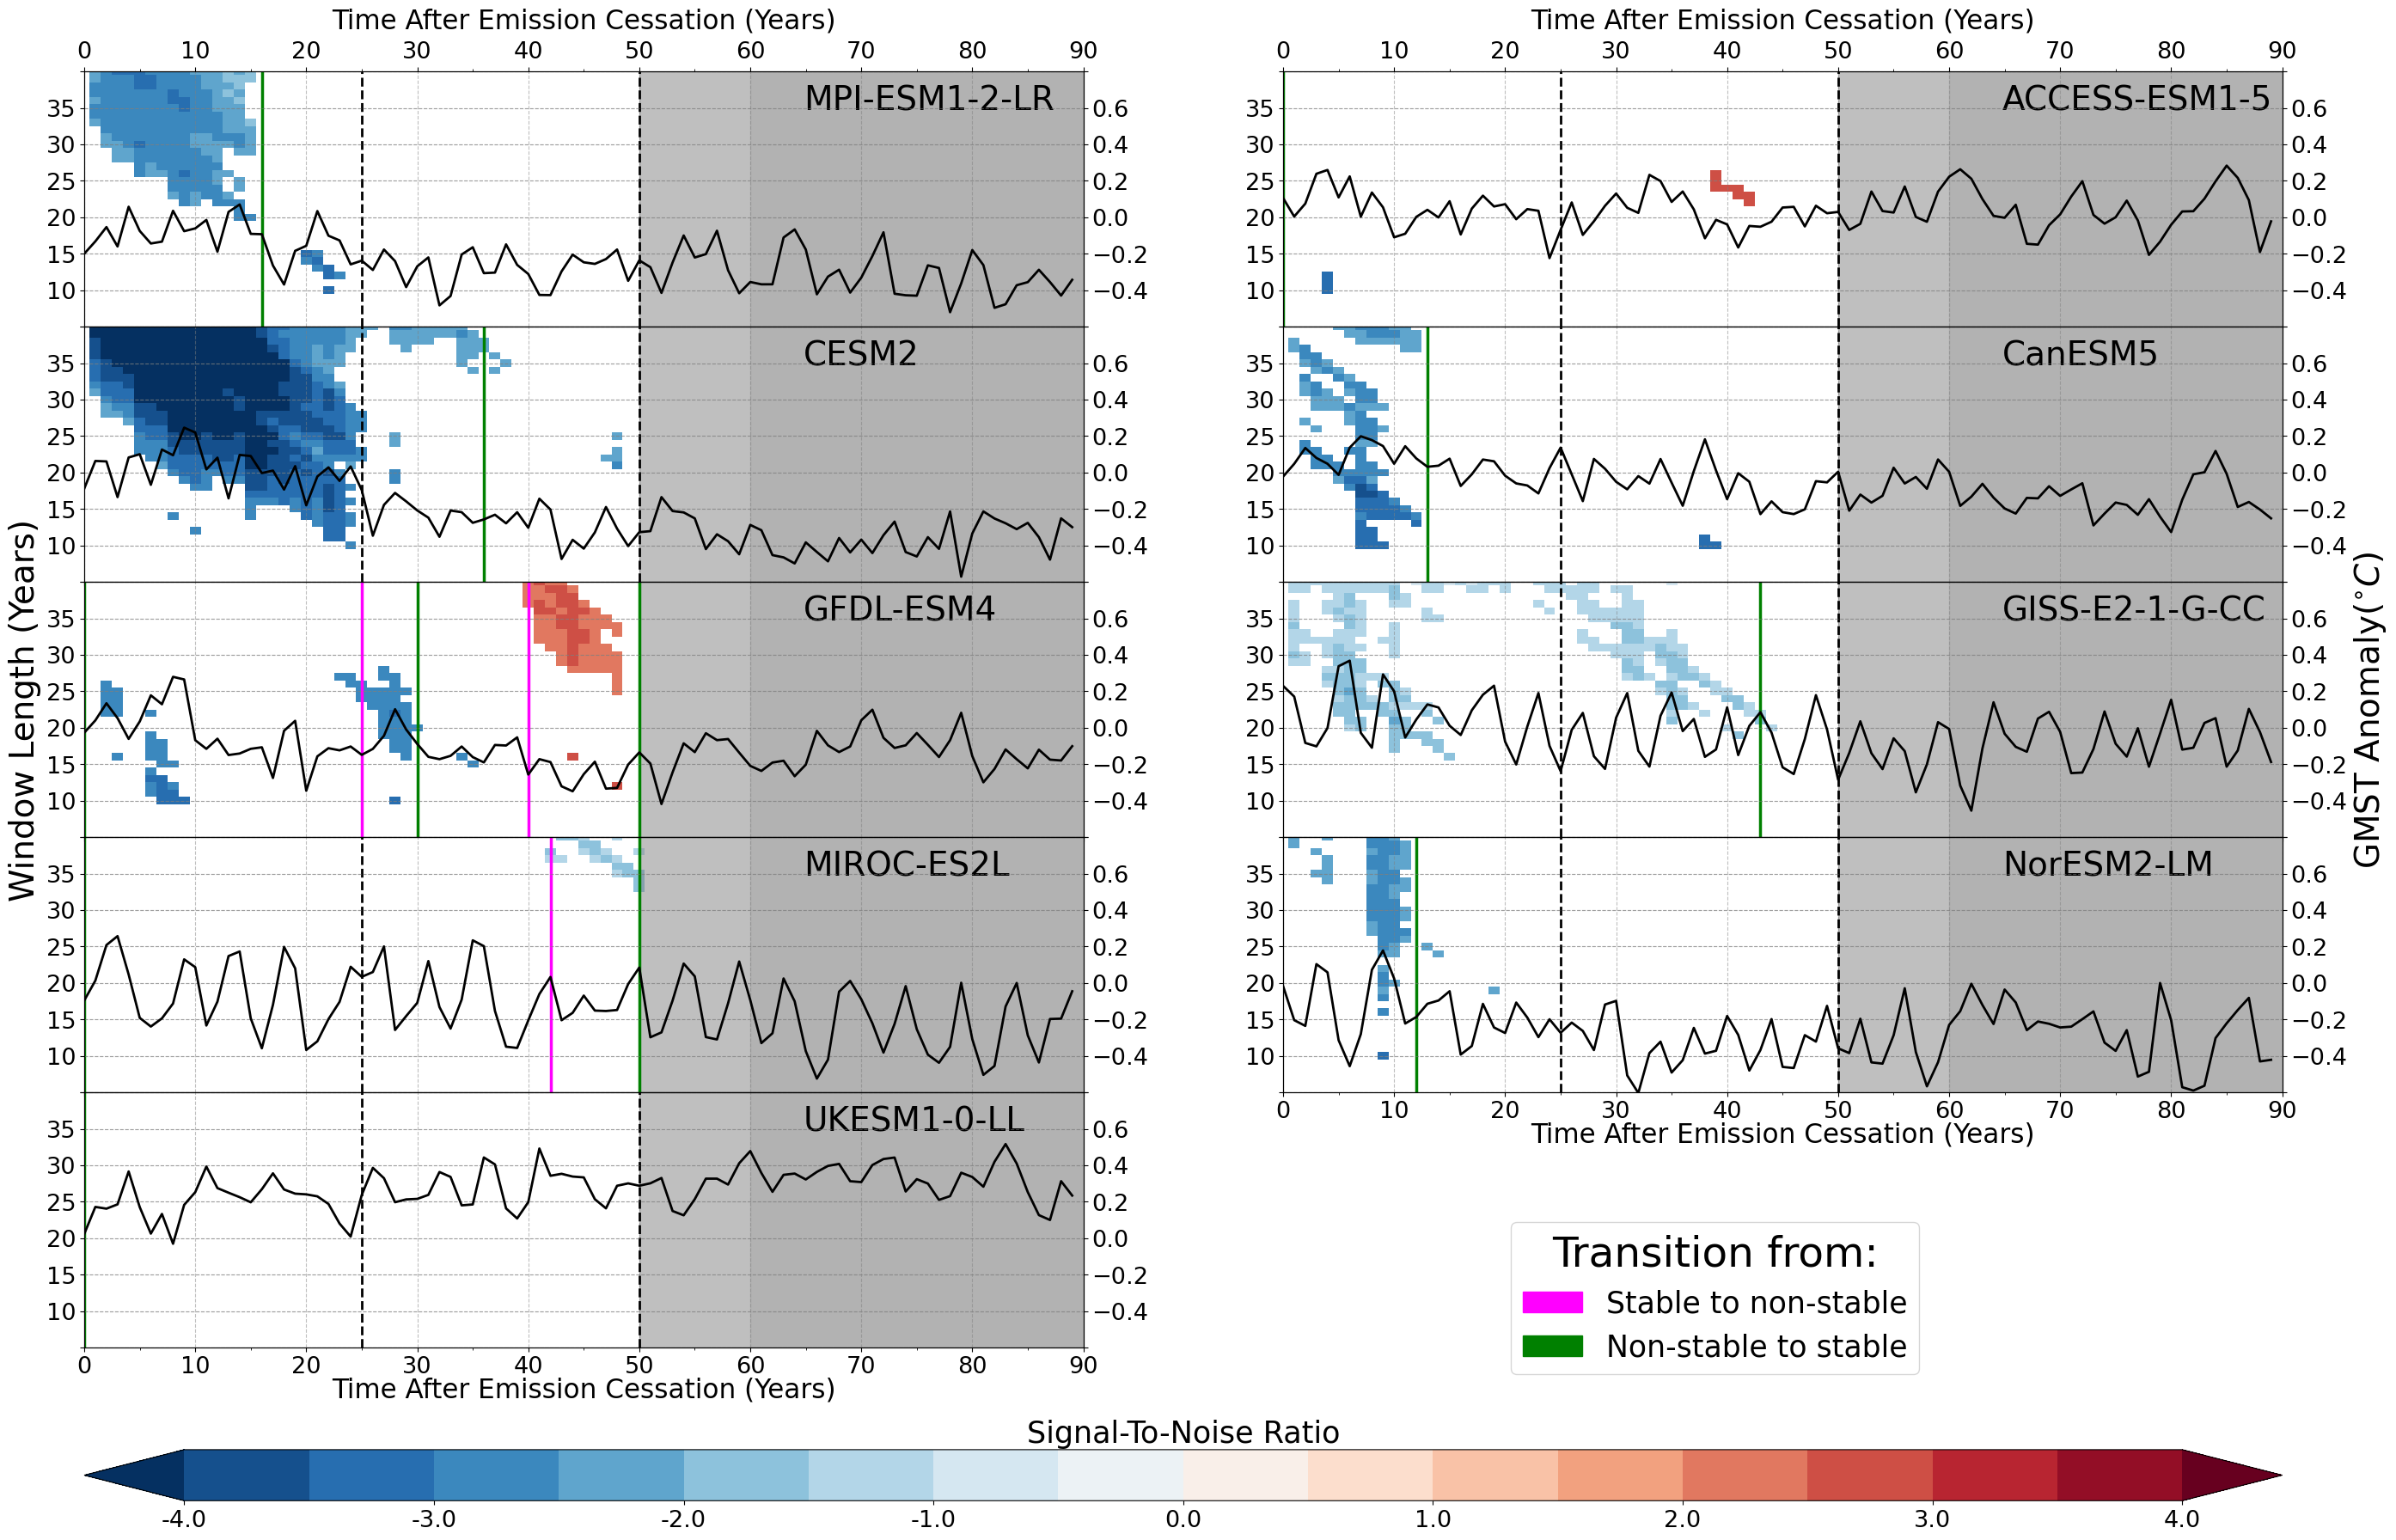

In [381]:
%matplotlib inline
models = unstable_rolling_ds.model.values
font_scale = 1.4

num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]

for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        unstable_rolling_ds.sel(model=model).squeeze().signal_to_noise.isel(time=slice(0, 50)),
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs) 
    
    ax, ax2, cax = returned_axes

    # Lines at zec25 and zec50
    ax.axvline(25, 0, 1000, color='k', linewidth=2, linestyle='--')
    ax.axvline(50, 0, 1000, color='k', linewidth=2, linestyle='--')

    for snum,year in enumerate(year_stable_and_unstable_rolling_ds.sel(model=model).values):
        ax.axvline(year, c=line_colors[snum%2], linewidth=2.5)

    ax.axvspan(50, 90, color='grey', alpha=0.5)

    
    plotting_functions.clip_axis_ends(ax)
    plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    ax2.set_ylabel('')
    if num  == 4: ax.set_ylabel('Window Length (Years)', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num  == 5: ax2.set_ylabel(f'GMST Anomaly({units})', size=plotting_functions.PlotConfig.title_size*font_scale)
    ax.annotate(model, xy=(0.72, 0.85), xycoords='axes fraction', ha='left', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num <= 1:
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    
    if 1 < num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')

magenta_patch = mpatches.Patch(color='magenta', label='Stable to non-stable')
green_patch = mpatches.Patch(color='green', label='Non-stable to stable' )
leg = fig.legend(handles=[magenta_patch, green_patch], loc='lower center', ncol=1, fontsize=25, bbox_to_anchor=[0.7, 0.17])
leg.set_title('Transition from:', prop={'size': 35})

## Supplementary Figures

### Figure S1 (ZEC Time Series)

In [106]:
models = a1_smean_anom_ds.model.values

In [107]:

def plot_zecmip_data(ax, a1_model_subset, pct_model_subset, zec50_anom, zec25_anom):
    branch_year = a1_model_subset.time.values[0].year
    base_period_years =  np.arange(branch_year-10, branch_year+10)
    
    pct_brach_subset = pct_model_subset.sel(
        time=pct_model_subset.time.dt.year.isin(base_period_years))

    a1_time = np.arange(0, len(a1_model_subset.time.values))
    pct_time = np.arange(-10, 10)
    
    base_period_mean = pct_brach_subset.mean(dim='time').values
    
    
    ax.plot(
        a1_time,
        # a1_model_subset.time.values,
        np.tile(base_period_mean, len(a1_model_subset.time.values)),
        linestyle='--', color='k', label='Base Period Average')
    
    ax.plot(pct_time, pct_brach_subset.values, color='magenta', label='Base Period',
           # linestyle='--', marker='o'
           )
    
    ax.plot(a1_time, a1_model_subset.values, color='green', linewidth=2, label='A1')

    #### ZEC50
    zec50_loc = a1_model_subset.isel(time=slice(40, 60)).mean().values
    # zec50_val= zec50_loc
    ax.plot(np.arange(40, 60),
            np.tile(zec50_loc, 20),
            color='blue', linewidth=2)
    if zec50_loc < base_period_mean: ytrans = -0.2
    else: ytrans = 0.2
    ax.annotate(f'{zec50_anom:.2f}', xy=(50,zec50_loc+ytrans), ha='center', color='blue')

    ### ZEC25
    zec25_loc = a1_model_subset.isel(time=slice(15, 35)).mean().values
    # zec50_val= zec50_loc
    ax.plot(np.arange(15, 35),
            np.tile(zec25_loc, 20),
            color='brown', linewidth=2)
    if zec25_loc < base_period_mean: ytrans = -0.2
    else: ytrans = 0.2
    ax.annotate(f'{zec25_anom:.2f}', xy=(25,zec25_loc+ytrans), ha='center', color='brown')
    
    
    ax.axvline(0, label='Branch Point')
    
    ### Styling
    ax.grid(True, linestyle='--', color='grey', alpha=0.5)

Text(0.5, 0, 'Time After Emission Cessation (Years)')

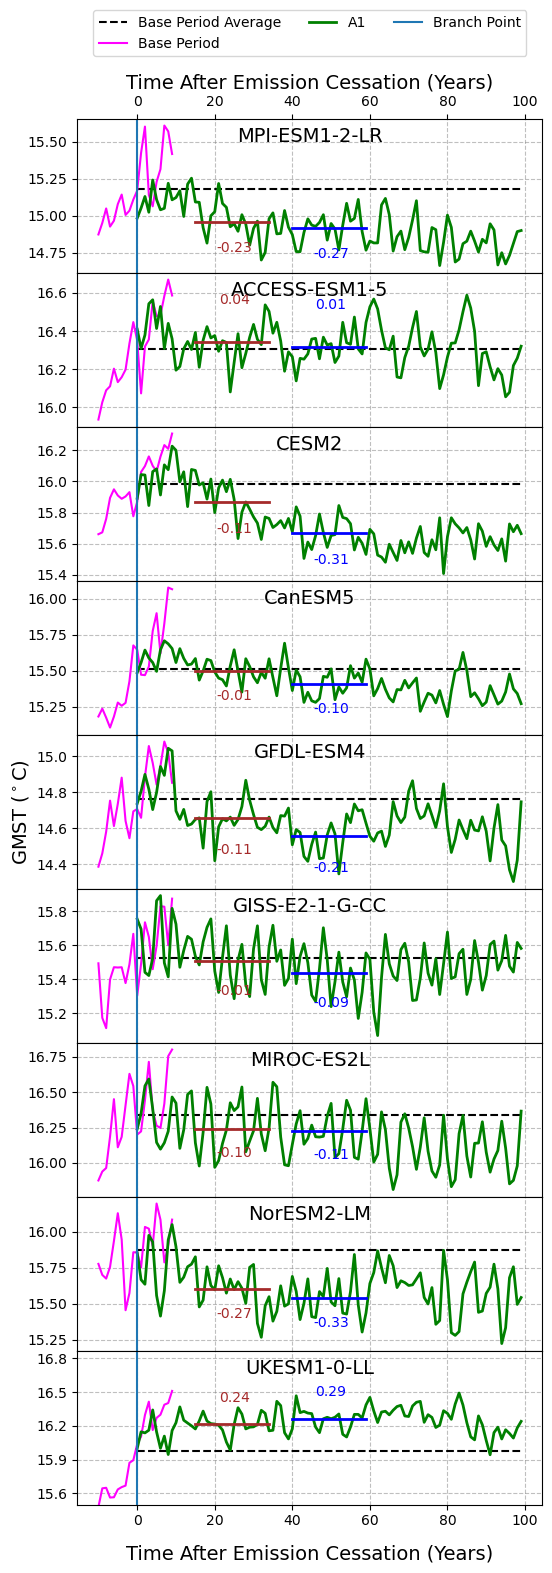

In [108]:
# ncols = 2
# nrows = int(np.ceil(len(models)/ncols))

# fig = plt.figure(figsize=(6*ncols, 2*nrows))
# gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=0.1)
# axes = [fig.add_subplot(gs[i]) for i in range(9)]

ncols = 1
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

# Iterate over the models and plot each one using plot_model_data
for num, model in enumerate(pct_smean_xrlist.refkeys):
    plot_zecmip_data(axes[num], a1_smean_xrlist[model].squeeze(), pct_smean_xrlist[model].squeeze(),
                    zec50_ds.sel(model=model).values.item(), zec25_ds.sel(model=model).values.item())
    # plot_model_data(axes[num], model, ds_pct, a1_smean_xrlist[model])
    axes[num].annotate(model, xy=(0.5, 0.85), ha='center', fontsize=14, xycoords='axes fraction')

    if model == 'UKESM1-0-LL': axes[num].set_ylim(15.5, 16.87)
    axes[num].yaxis.set_major_locator(MaxNLocator(nbins=5))
    # Add y-axis label to the middle left subplot
    if num == int(len(models)/2):
        axes[num].set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)

    if num == 0:
        axes[num].xaxis.set_label_position('top')
        axes[num].xaxis.tick_top()
    


# Place the legend above the first row of plots
# leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
leg = axes[0].legend(ncol=3, bbox_to_anchor=[0.5, 1.75], loc='upper center', fontsize=10)

# Add x-axis label to the last subplot
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)
axes[0].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=2)

### Figure S2 (Global Drift)

In [109]:
import pymannkendall

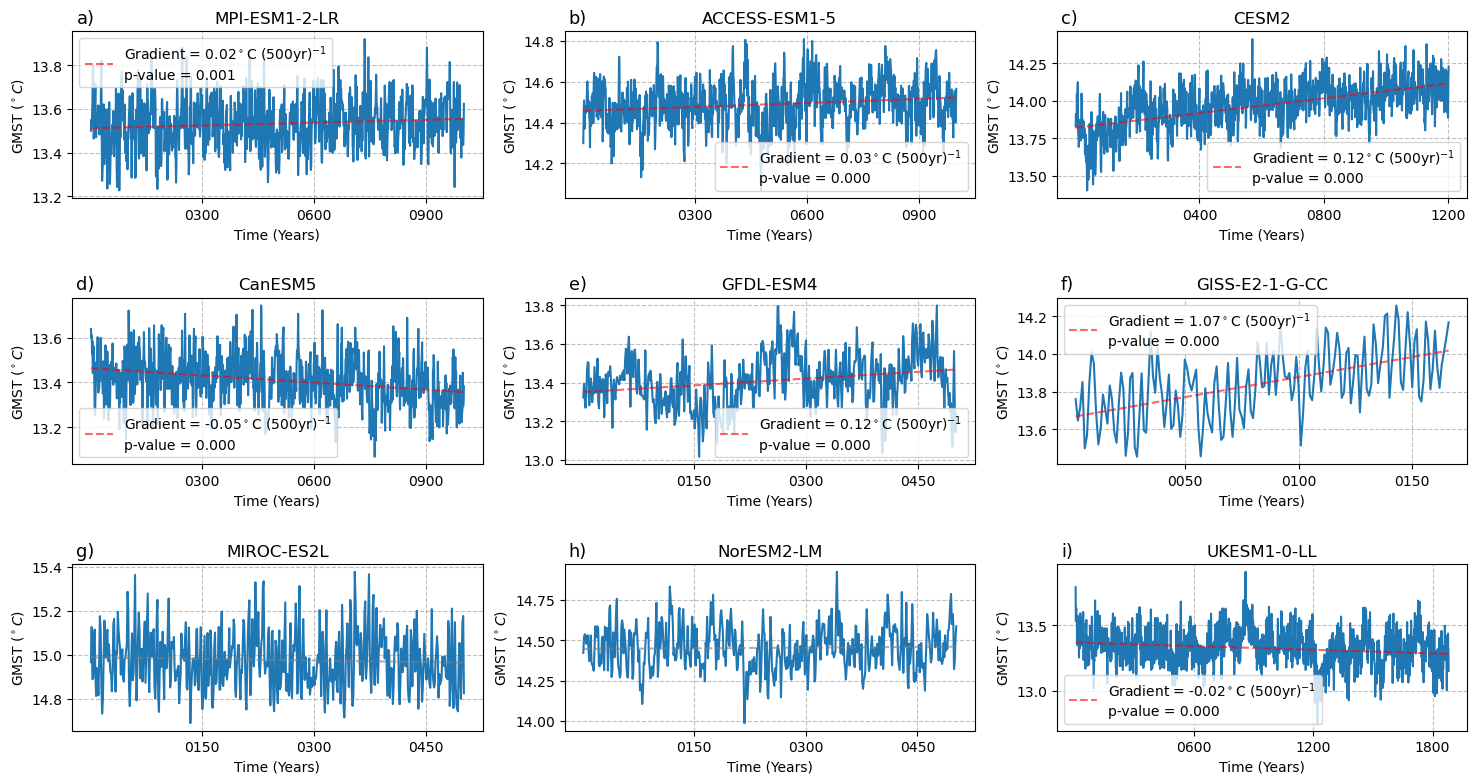

In [110]:
models = esmpi_smean_xrlist.refkeys
ncols = 3; nrows = int(np.ceil(len(models)/2))

fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, hspace=0.6)

for num, (model, ds) in enumerate(esmpi_smean_xrlist):
    ax = fig.add_subplot(gs[num])
    time = utils.convert_to_0_start_cftime(ds.time.values)
    ax.plot(time,ds.squeeze())
    
    plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.8)
    ax.set_title(model); ax.set_ylabel(r'GMST $(^\circ C)$'); ax.set_xlabel('Time (Years)')
    # ax.set_xlim([time[0], time[-1]])
    
    init_y = ds.squeeze().values
    x = np.arange(len(init_y))
    grad_yint = np.polyfit(x, init_y, deg=1)

    fitted_line = np.polyval(grad_yint, x)
    mk_val = pymannkendall.original_test(init_y)
    mk_pval = mk_val.p
    if mk_pval < 0.05:
        color = 'red'
        label = f'Gradient = {grad_yint[0]*500:.2f}' + r'$^\circ$C (500yr)$^{-1}$' + f'\np-value = {mk_pval:.3f}'
    else:
        color='grey'
        label=None
    
    ax.plot(time, fitted_line, linestyle='--', alpha=0.6, color=color, label=label)
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    if mk_pval < 0.05: ax.legend(ncol=1, loc='best')#bbox_to_anchor=(0.6, 1.06))

### Fig S3 ( Method Demonstration)

In [111]:
# Manual Calculation for Demonstations
WINDOW=25
# Sample period is the years that we want to look at
sample_period = (0,70) #(1200,1261), 61

# The length of the sample_period varible
window_length = WINDOW
imodel = 2

In [112]:
sample_data = a1_smean_anom_ds.isel(time=slice(*sample_period), model=imodel)
sample_data

<xarray.DataArray 'tas' (time: 70)> Size: 560B
-0.08847 0.06323 0.06065 -0.1351 0.08224 ... -0.4361 -0.4874 -0.3594 -0.4383
Coordinates:
    model    <U14 56B 'CESM2'
  * time     (time) object 560B 0001-12-31 00:00:00 ... 0070-12-31 00:00:00

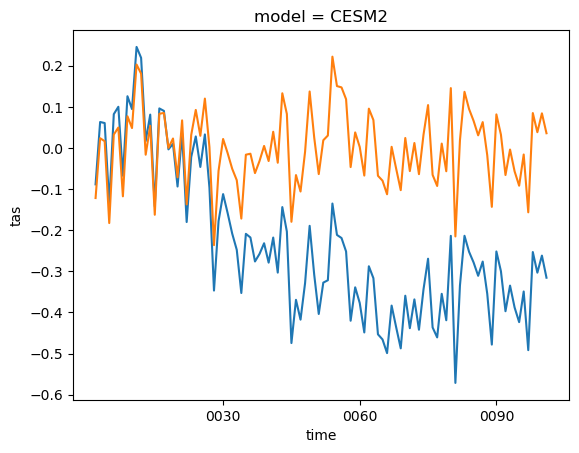

In [113]:
a1_smean_anom_ds.isel(model=imodel).plot()
a1_smean_anom_detrend_ds.isel(model=imodel).plot()

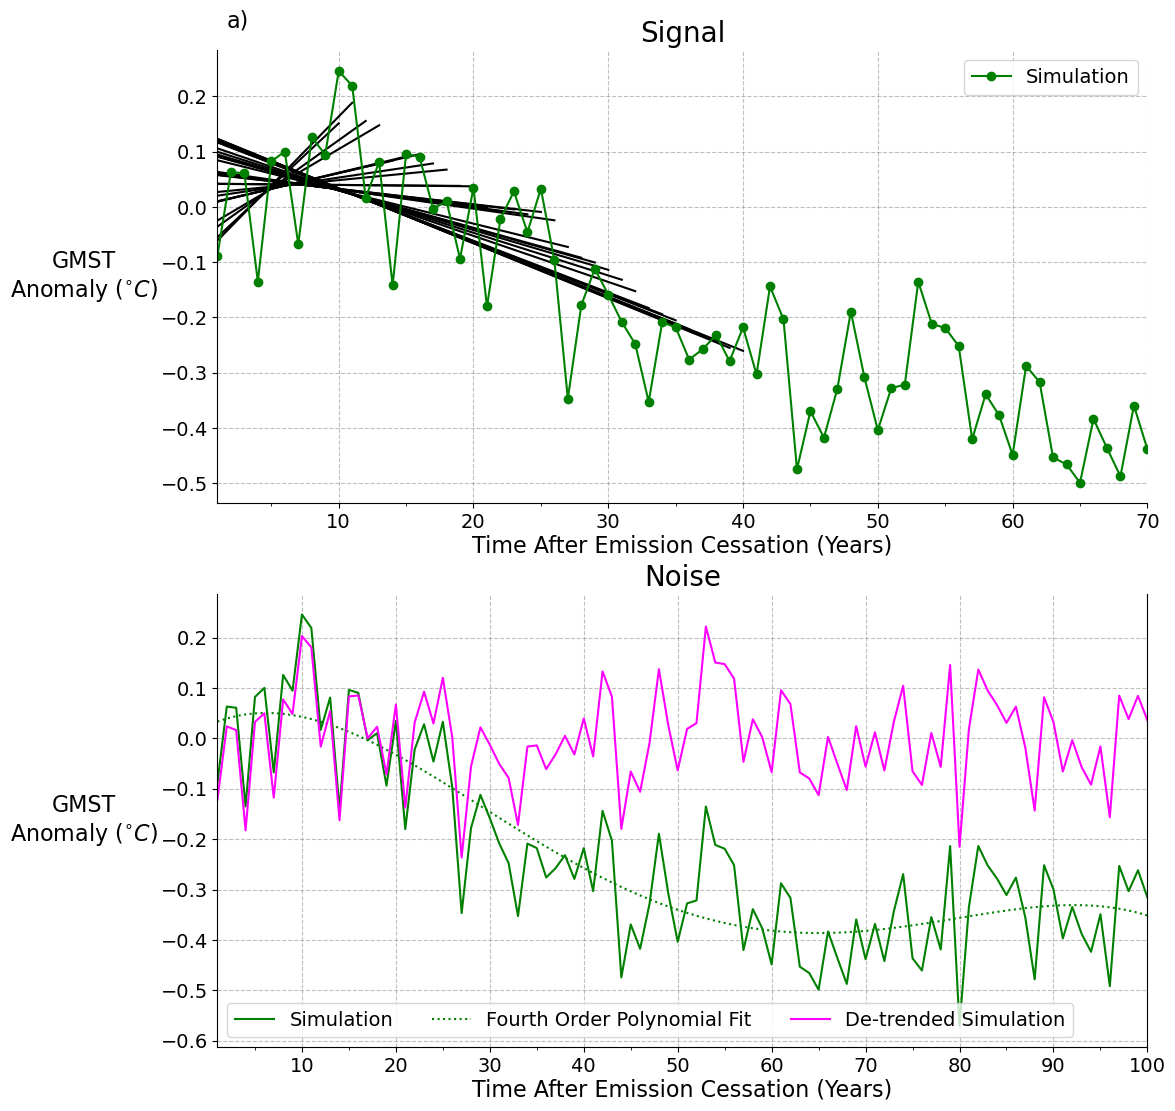

In [114]:
plt.style.use('default')
fig = plt.figure(figsize=(12,20))
axes = [fig.add_subplot(3,1,i) for i in range(1,3)]


# ---> axes[0]
# axes[0].plot(sample_data.time.dt.year.values, a1_smean_anom_trendfit_ds.isel(time=slice(*sample_period), model=imodel),
#              label='Linear Trend Fit', color='blue')

for window_length in range(10, 41):
    arr = sample_data.isel(time=slice(0, window_length))
    x = np.arange(len(arr))
    coeffs= np.polyfit(x, arr, deg=1)
    yhat = np.polyval(coeffs, x)
    axes[0].plot(sample_data.time.dt.year.values[:len(yhat)], yhat, color='black')

axes[0].plot(sample_data.time.dt.year.values, sample_data.values, marker='o', label='Simulation',
             color='green')


axes[0].set_xlim(sample_data.time.dt.year.values[0], sample_data.time.dt.year.values[-1])
axes[0].legend(ncol=2, fontsize=plotting_functions.PlotConfig.legend_text_size)

plotting_functions.format_axis(axes[0], title='Signal', xlabel='Time After Emission Cessation (Years)', ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)',
                               labelpad=55, invisible_spines=['top', 'right'])
plotting_functions.add_figure_label(axes[0], 'a)')
sn_plotting.format_ticks_as_years(axes[0], sample_data.time.dt.year.values, logginglevel='ERROR')

# ---> axes[1]
# ax1 = axes[1]; ax2 = ax1#axes[1].twinx()
ax1 = axes[1]
time = a1_smean_anom_ds.time.dt.year.values
lns1 = ax1.plot(time, a1_smean_anom_ds.isel(model=imodel).values, color='green', label='Simulation')
lns2 = ax1.plot(time, a1_smean_anom_trendfit_ds.isel(model=imodel).values, label='Fourth Order Polynomial Fit',
                color='green', linestyle=':')
lns3 = ax1.plot(time, a1_smean_anom_detrend_ds.isel(model=imodel).values, label='De-trended Simulation',
                color='magenta')
sn_plotting.format_ticks_as_years(axes[1], time, logginglevel='ERROR')
ax1.set_xlim(np.take(time, [0, -1]))

plotting_functions.format_axis(ax1, title='Noise', xlabel='Time After Emission Cessation (Years)', ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)',
                               labelpad=55, invisible_spines=['top'])

ax1.legend(ncol=3, loc='best', fontsize=plotting_functions.PlotConfig.legend_text_size)# let
# plotting_functions.match_ticks(ax1, ax2, 'left')

# lns = lns1+lns2+lns3
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, ncol=3, loc='best', fontsize=plotting_functions.PlotConfig.legend_text_size)
# plotting_functions.format_axis(ax2, title='Noise', ylabel='GMST\nAnomaly\nDetrended' + r'($^{\circ}C$)',
#                                labelpad=55, invisible_spines=['top'])
# plotting_functions.add_figure_label(ax1, 'b)')

# Figure S4 (Stable and unstable demonstration)

[Text(-725008, 0, '15'),
 Text(-719529, 0, '30'),
 Text(-714050, 0, '45'),
 Text(-708572, 0, '60'),
 Text(-703093, 0, '')]

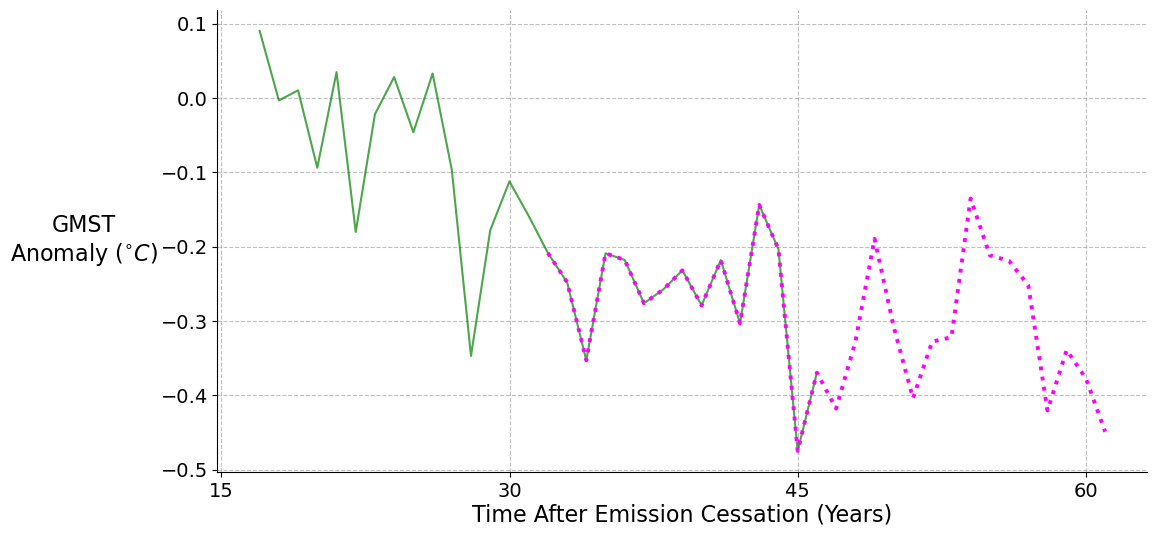

In [115]:
plt.style.use('default')
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

a1_smean_anom_ds.sel(model='CESM2').isel(time=slice(15, 45)).plot(color='green', alpha=0.7)
a1_smean_anom_ds.sel(model='CESM2').isel(time=slice(30, 60)).plot(
    color='magenta',linestyle=':', linewidth=2.8)

plotting_functions.format_axis(
    ax1, xlabel='Time After Emission Cessation (Years)', title='',
    ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)',
    labelpad=55, invisible_spines=['top', 'right'])
ax1.set_title('')

# sn_plotting.format_ticks_as_years(ax1, a1_smean_anom_ds.isel(time=slice(15, 60)).time.dt.year.values,
#                                   logginglevel='ERROR')

ax1.set_xticklabels(a1_smean_anom_ds.isel(time=slice(14, 60)).time.dt.year.values[::15])

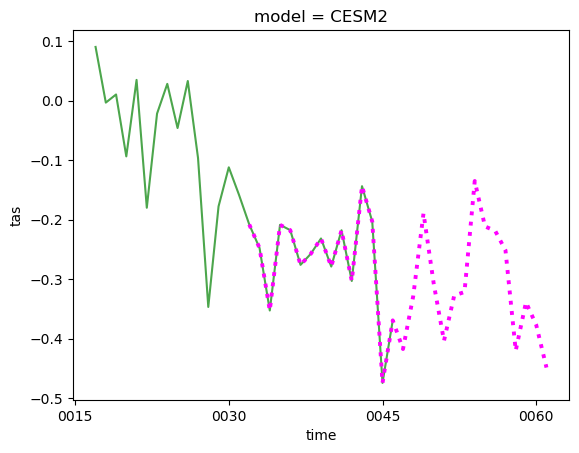

In [116]:
a1_smean_anom_ds.sel(model='CESM2').isel(time=slice(15, 45)).plot(color='green', alpha=0.7)
a1_smean_anom_ds.sel(model='CESM2').isel(time=slice(30, 60)).plot(color='magenta',linestyle=':',
                                                                 linewidth=2.8)

### Figure S4-S6 (S, S/N, N at each window)

In [117]:
sn_multi_static_da

<xarray.DataArray 'signal_to_noise' (window: 31, model: 9, time: 90)> Size: 201kB
1.024 0.4641 0.4069 -0.183 -0.1691 1.196 0.897 ... nan nan nan nan nan nan nan
Coordinates:
  * model    (model) <U14 504B 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * time     (time) object 720B 0001-12-31 00:00:00 ... 0090-12-31 00:00:00
  * window   (window) int64 248B 10 11 12 13 14 15 16 ... 34 35 36 37 38 39 40

In [118]:
stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=False, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

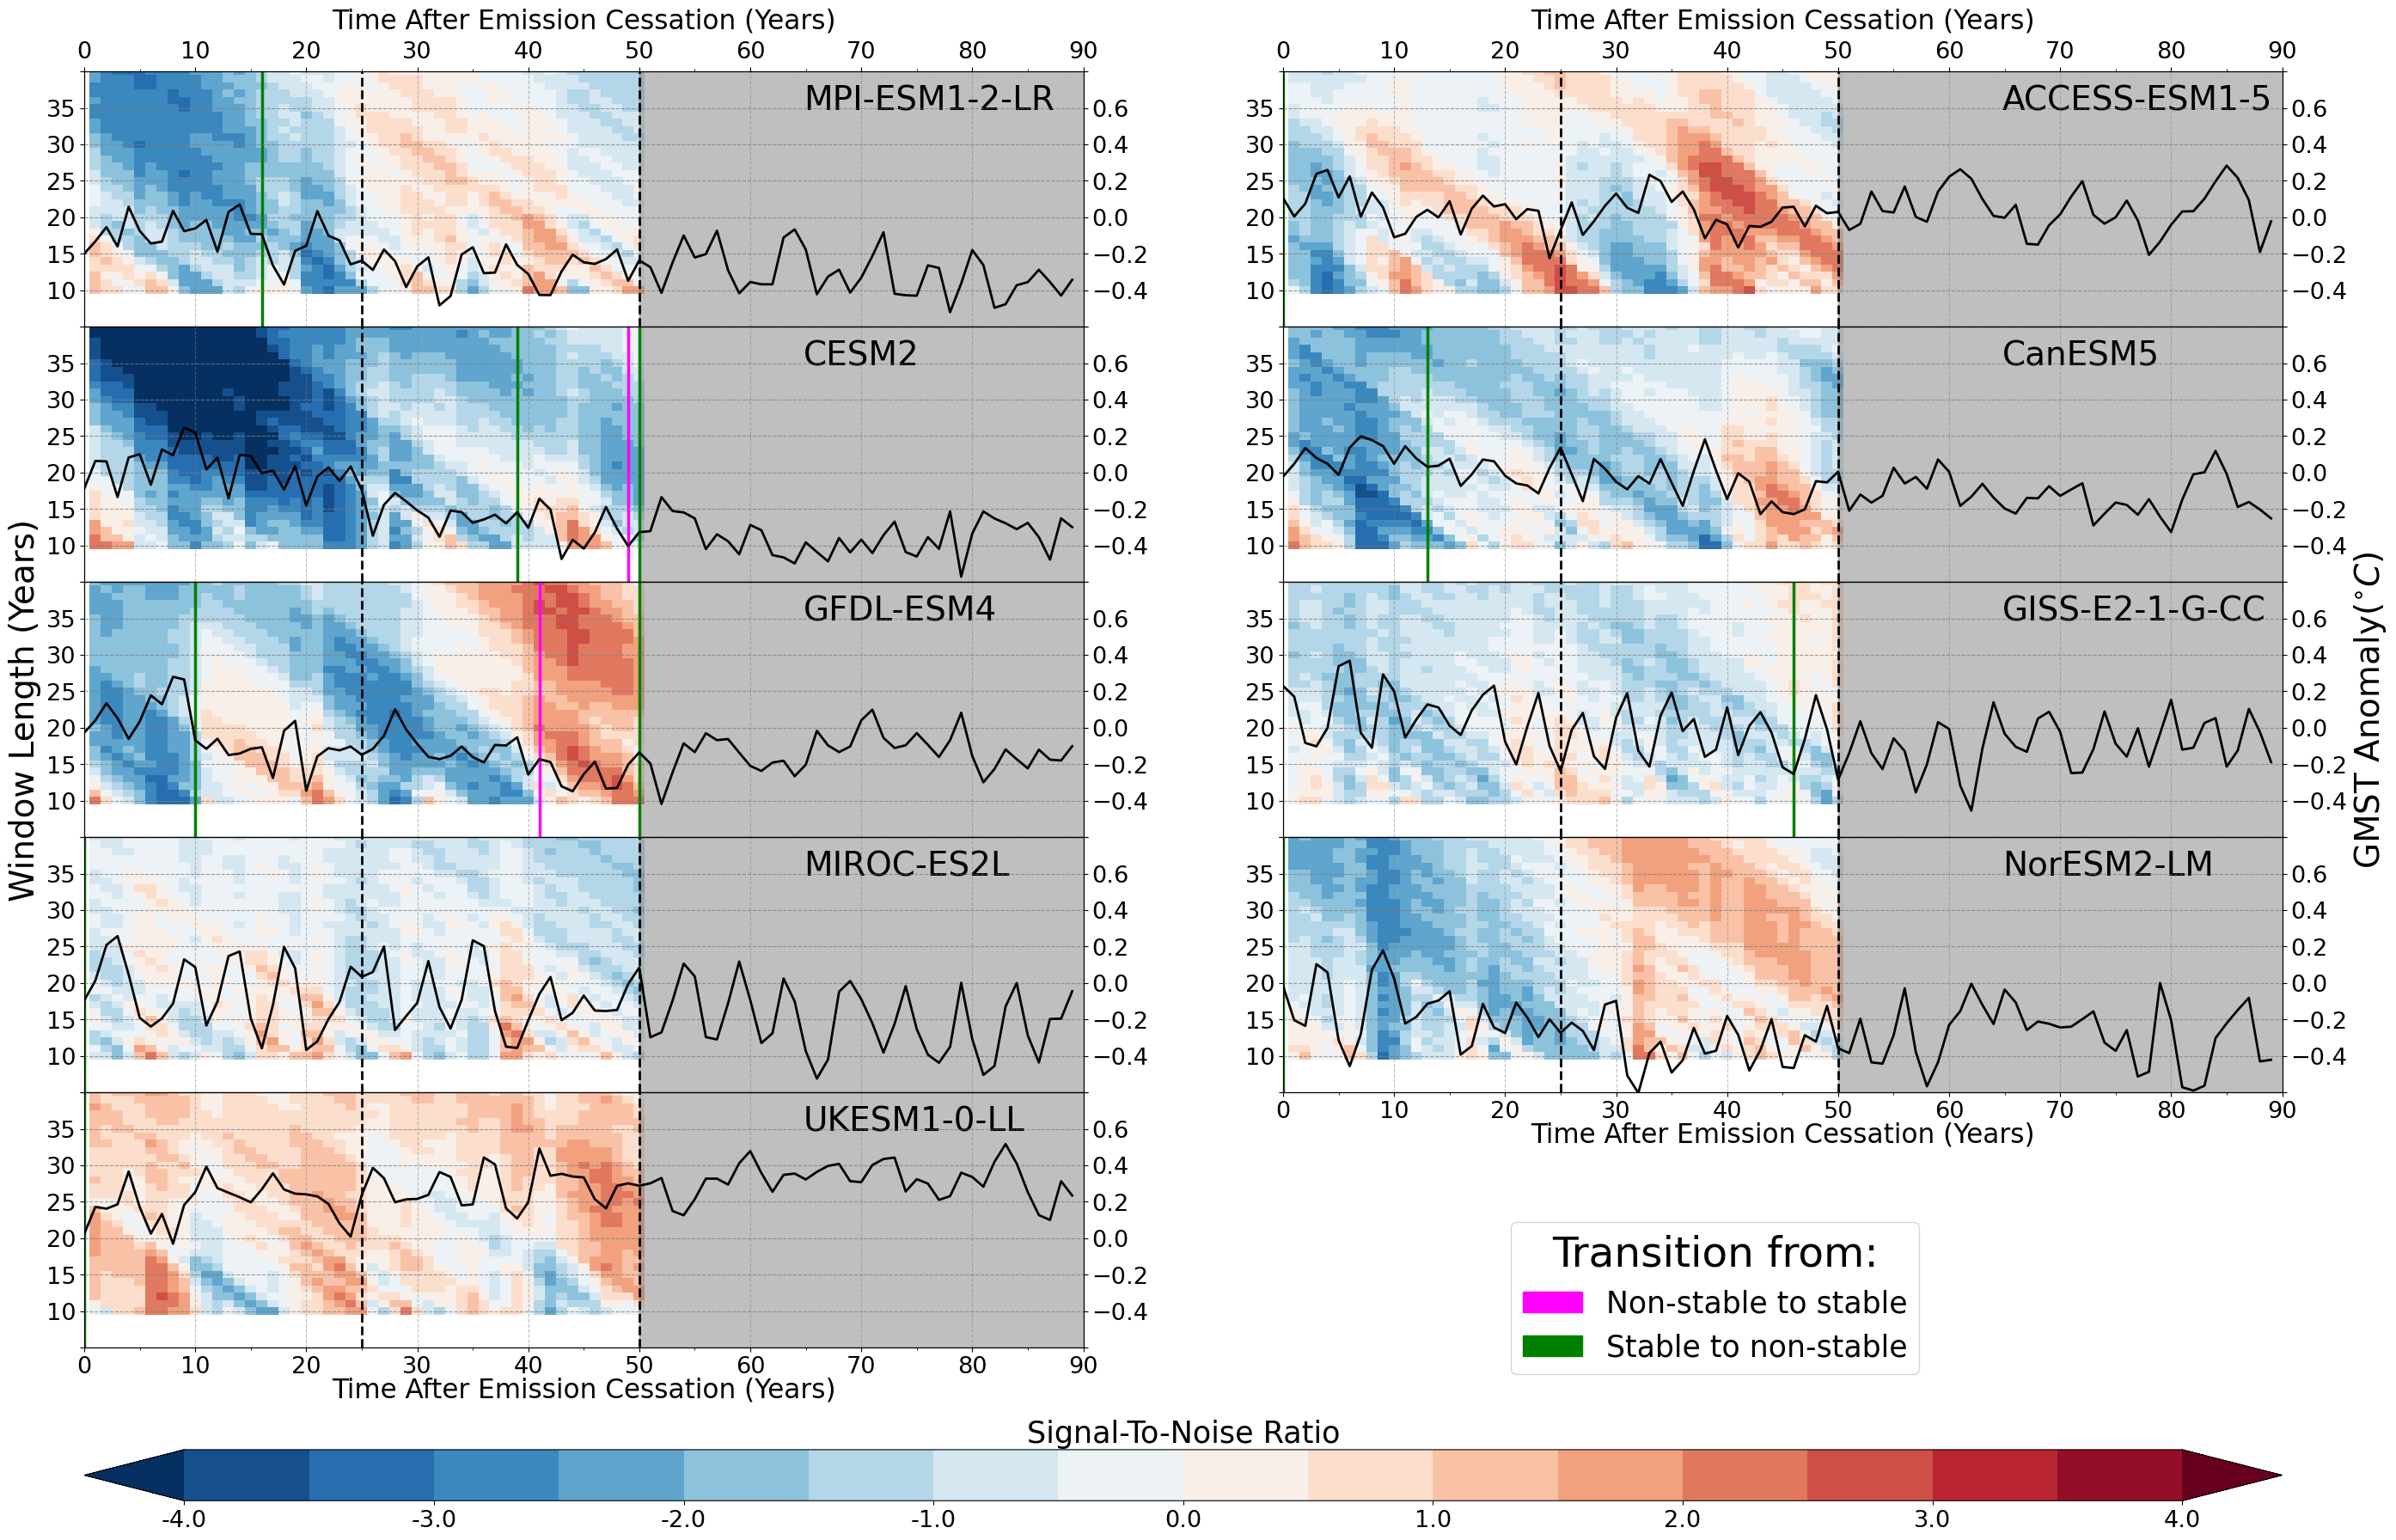

In [119]:
%matplotlib inline
models = unstable_rolling_ds.model.values
font_scale = 1.4


num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]

for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        sn_multi_rolling_ds.sel(model=model).isel(time=slice(None, 50)).squeeze().signal_to_noise,
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        # stable_point_ds = rolling_year_stable_ds.sel(model=model),#rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs) 
    
    ax, ax2, cax = returned_axes
    
    # Lines at zec25 and zec50
    ax.axvline(25, 0, 1000, color='k', linewidth=2, linestyle='--')
    ax.axvline(50, 0, 1000, color='k', linewidth=2, linestyle='--')

    for snum,year in enumerate(year_stable_and_unstable_static_ds.sel(model=model).values):
        ax.axvline(year, c=line_colors[snum%2], linewidth=2.5)

    ax.axvspan(50, 90, color='grey', alpha=0.5)

    
    plotting_functions.clip_axis_ends(ax)
    plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    ax2.set_ylabel('')
    if num  == 4: ax.set_ylabel('Window Length (Years)', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num  == 5: ax2.set_ylabel(f'GMST Anomaly({units})', size=plotting_functions.PlotConfig.title_size*font_scale)
    ax.annotate(model, xy=(0.72, 0.85), xycoords='axes fraction', ha='left', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num <= 1:
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    
    if 1 < num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')

magenta_patch = mpatches.Patch(color='magenta', label='Non-stable to stable')
green_patch = mpatches.Patch(color='green', label='Stable to non-stable')
leg = fig.legend(handles=[magenta_patch, green_patch], loc='lower center', ncol=1, fontsize=25, bbox_to_anchor=[0.7, 0.17])
leg.set_title('Transition from:', prop={'size': 35})

In [120]:
signal_colorplot_kwargs = {'max_color_lim': 60,
 'xlims': (0, 90),
 'patch': False,
 'ax2_ylabel': '',
 'ylabel': '',
 'cmap': 'RdBu_r',
 'bbox_to_anchor': (1, 1.4),
 'labelpad_left': 65,
 'labelpad_right': 15,
 'extend': 'both',
 'cut_ticks': 2,
 'vmax': .4,
 'step': 0.05,
 'font_scale': 1.4,
 'cbar_label': 'Signal (K)',
 'hspace': 0.2,
 'return_all': True,
 'rotation': 90}

In [121]:

stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=False, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

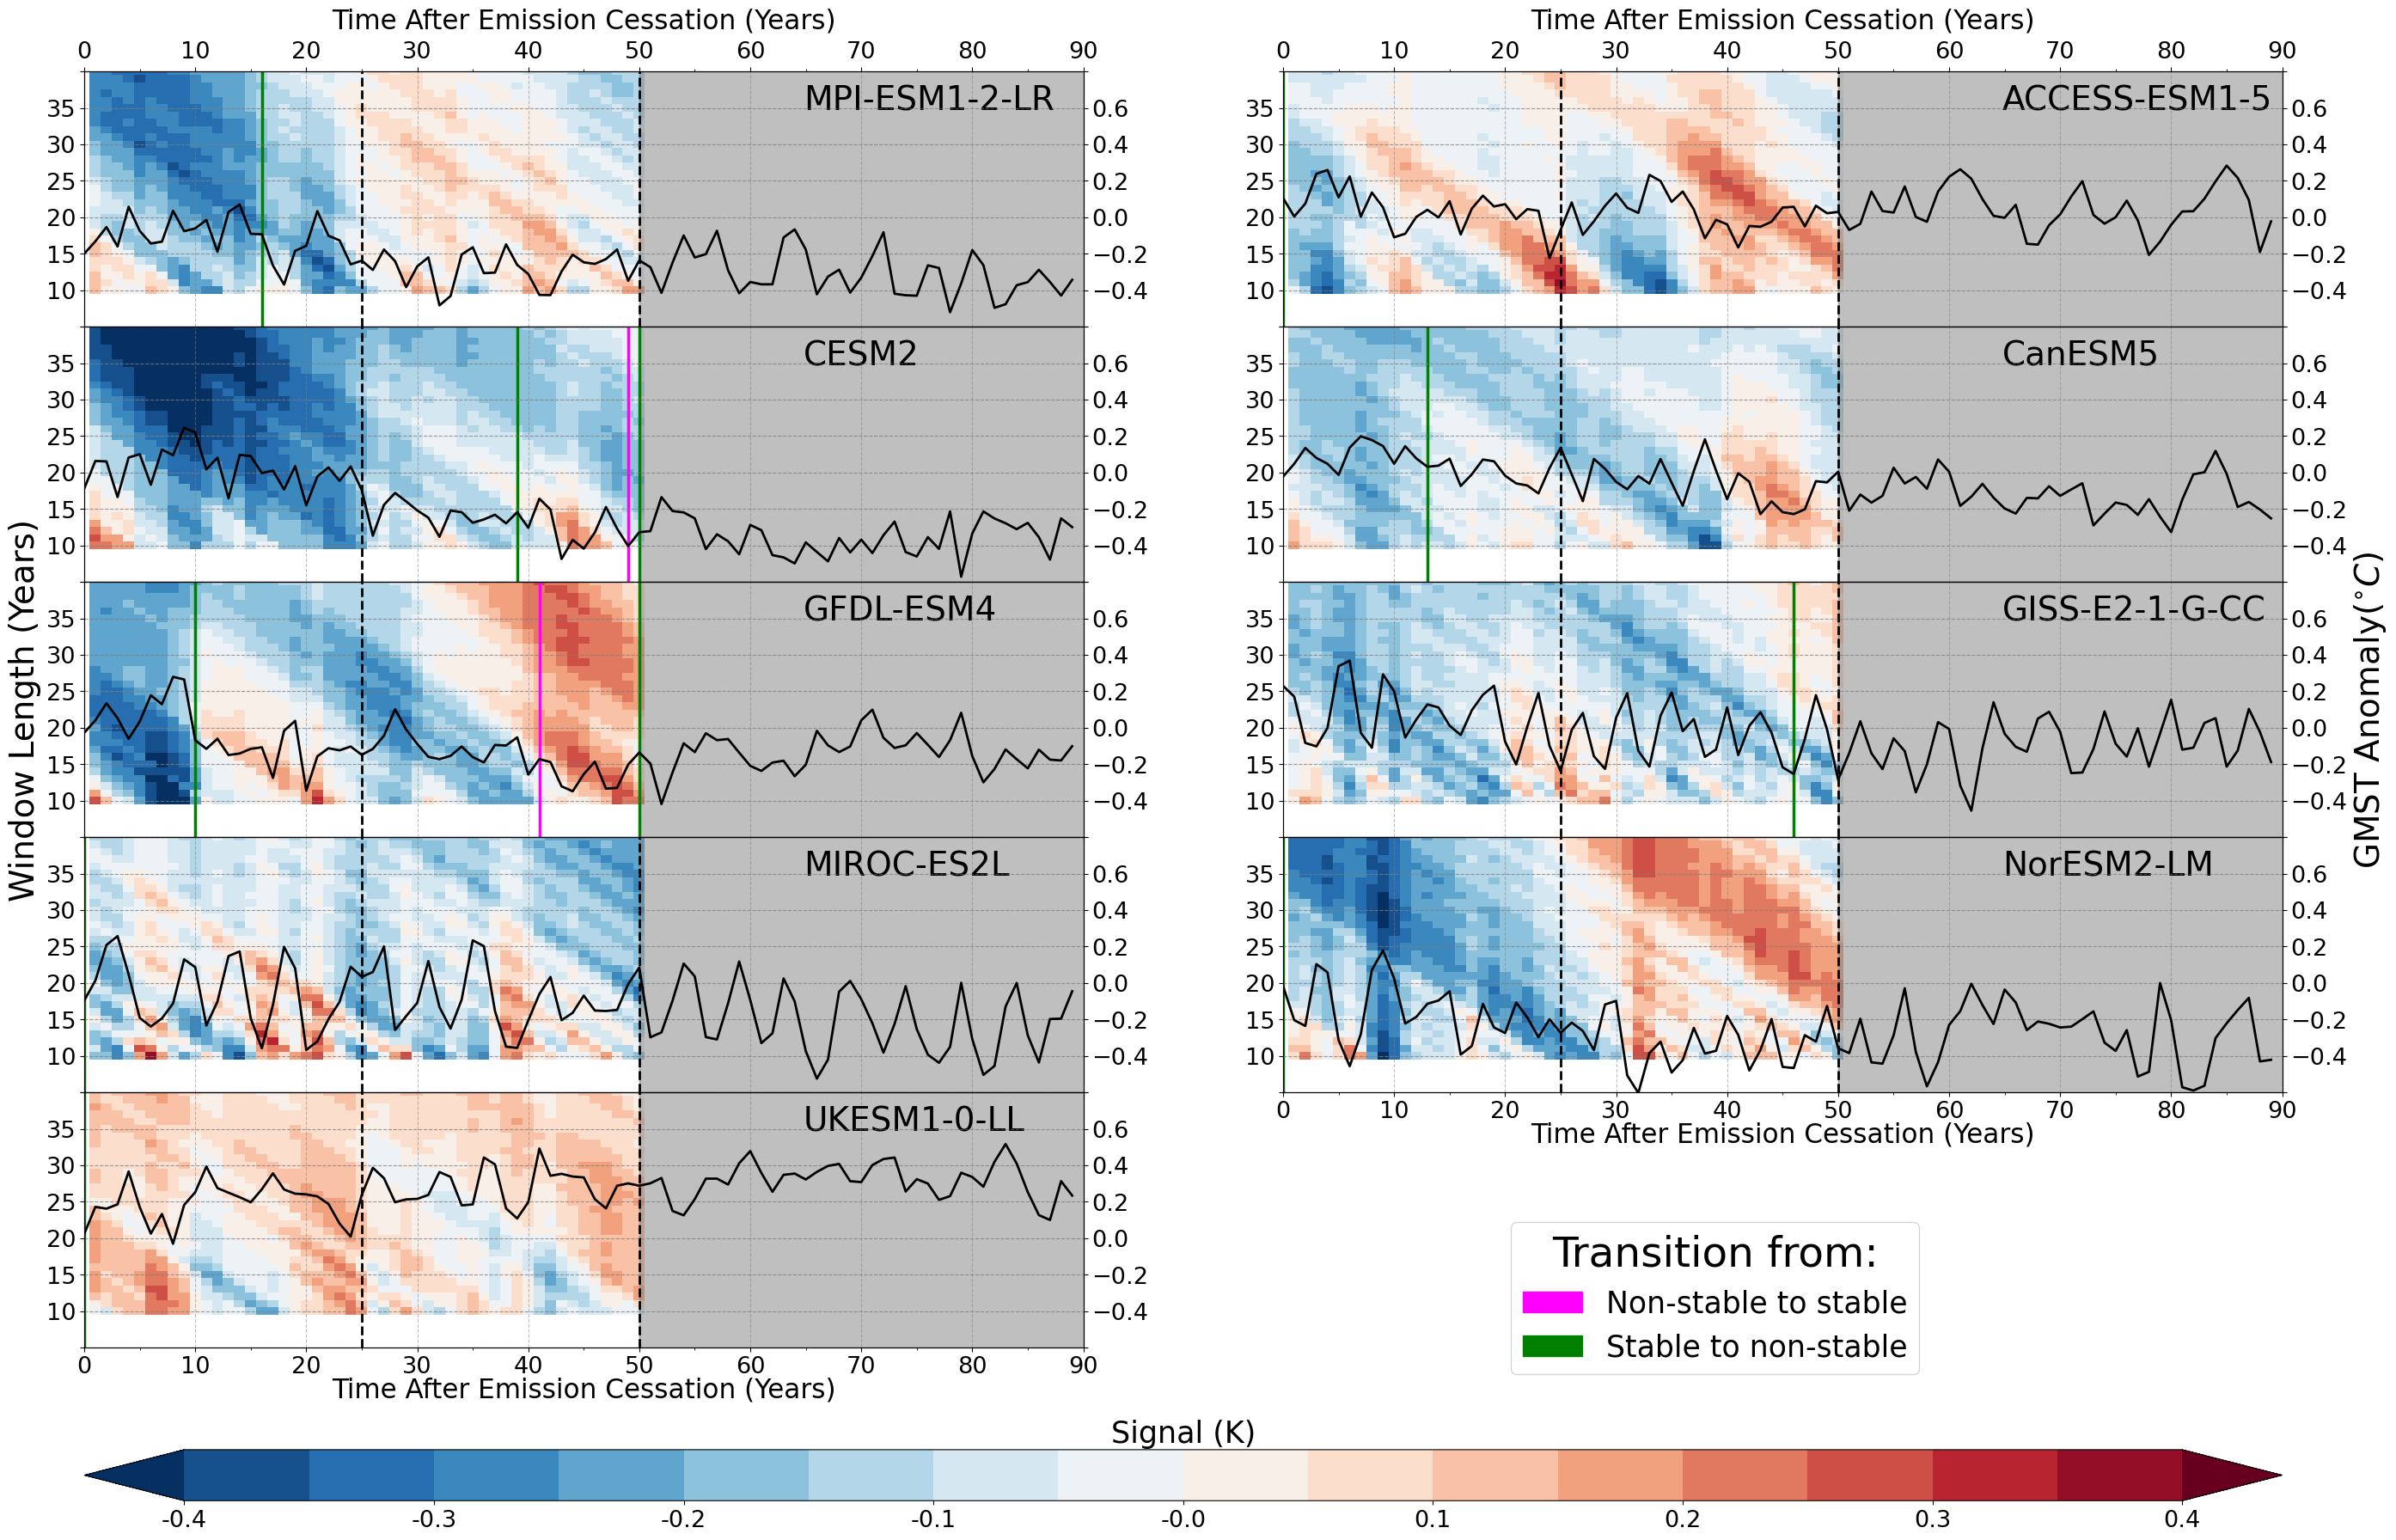

In [122]:
%matplotlib inline
models = unstable_rolling_ds.model.values
font_scale = 1.4


num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]

for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        signal_multi_rolling_da.sel(model=model).isel(time=slice(None, 50)).squeeze(), #sn_multi_rolling_ds
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        # stable_point_ds = rolling_year_stable_ds.sel(model=model),#rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **signal_colorplot_kwargs) 
    
    ax, ax2, cax = returned_axes
    
    # Lines at zec25 and zec50
    ax.axvline(25, 0, 1000, color='k', linewidth=2, linestyle='--')
    ax.axvline(50, 0, 1000, color='k', linewidth=2, linestyle='--')

    for snum,year in enumerate(year_stable_and_unstable_static_ds.sel(model=model).values):
        ax.axvline(year, c=line_colors[snum%2], linewidth=2.5)

    ax.axvspan(50, 90, color='grey', alpha=0.5)

    
    plotting_functions.clip_axis_ends(ax)
    plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    ax2.set_ylabel('')
    if num  == 4: ax.set_ylabel('Window Length (Years)', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num  == 5: ax2.set_ylabel(f'GMST Anomaly({units})', size=plotting_functions.PlotConfig.title_size*font_scale)
    ax.annotate(model, xy=(0.72, 0.85), xycoords='axes fraction', ha='left', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num <= 1:
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    
    if 1 < num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')

magenta_patch = mpatches.Patch(color='magenta', label='Non-stable to stable')
green_patch = mpatches.Patch(color='green', label='Stable to non-stable')
leg = fig.legend(handles=[magenta_patch, green_patch], loc='lower center', ncol=1, fontsize=25, bbox_to_anchor=[0.7, 0.17])
leg.set_title('Transition from:', prop={'size': 35})

In [123]:
noise_colorplot_kwargs = {'max_color_lim': 60,
 'xlims': (0, 90),
 'patch': False,
 'ax2_ylabel': '',
 'ylabel': '',
 'cmap': 'RdBu_r',
 'bbox_to_anchor': (1, 1.4),
 'labelpad_left': 65,
 'labelpad_right': 15,
 'extend': 'both',
 'cut_ticks': 2,
 'vmax': .2,
 'step': 0.025,
 'font_scale': 1.4,
 'cbar_label': 'Noise (K)',
 'hspace': 0.2,
 'return_all': True,
 'rotation': 90}

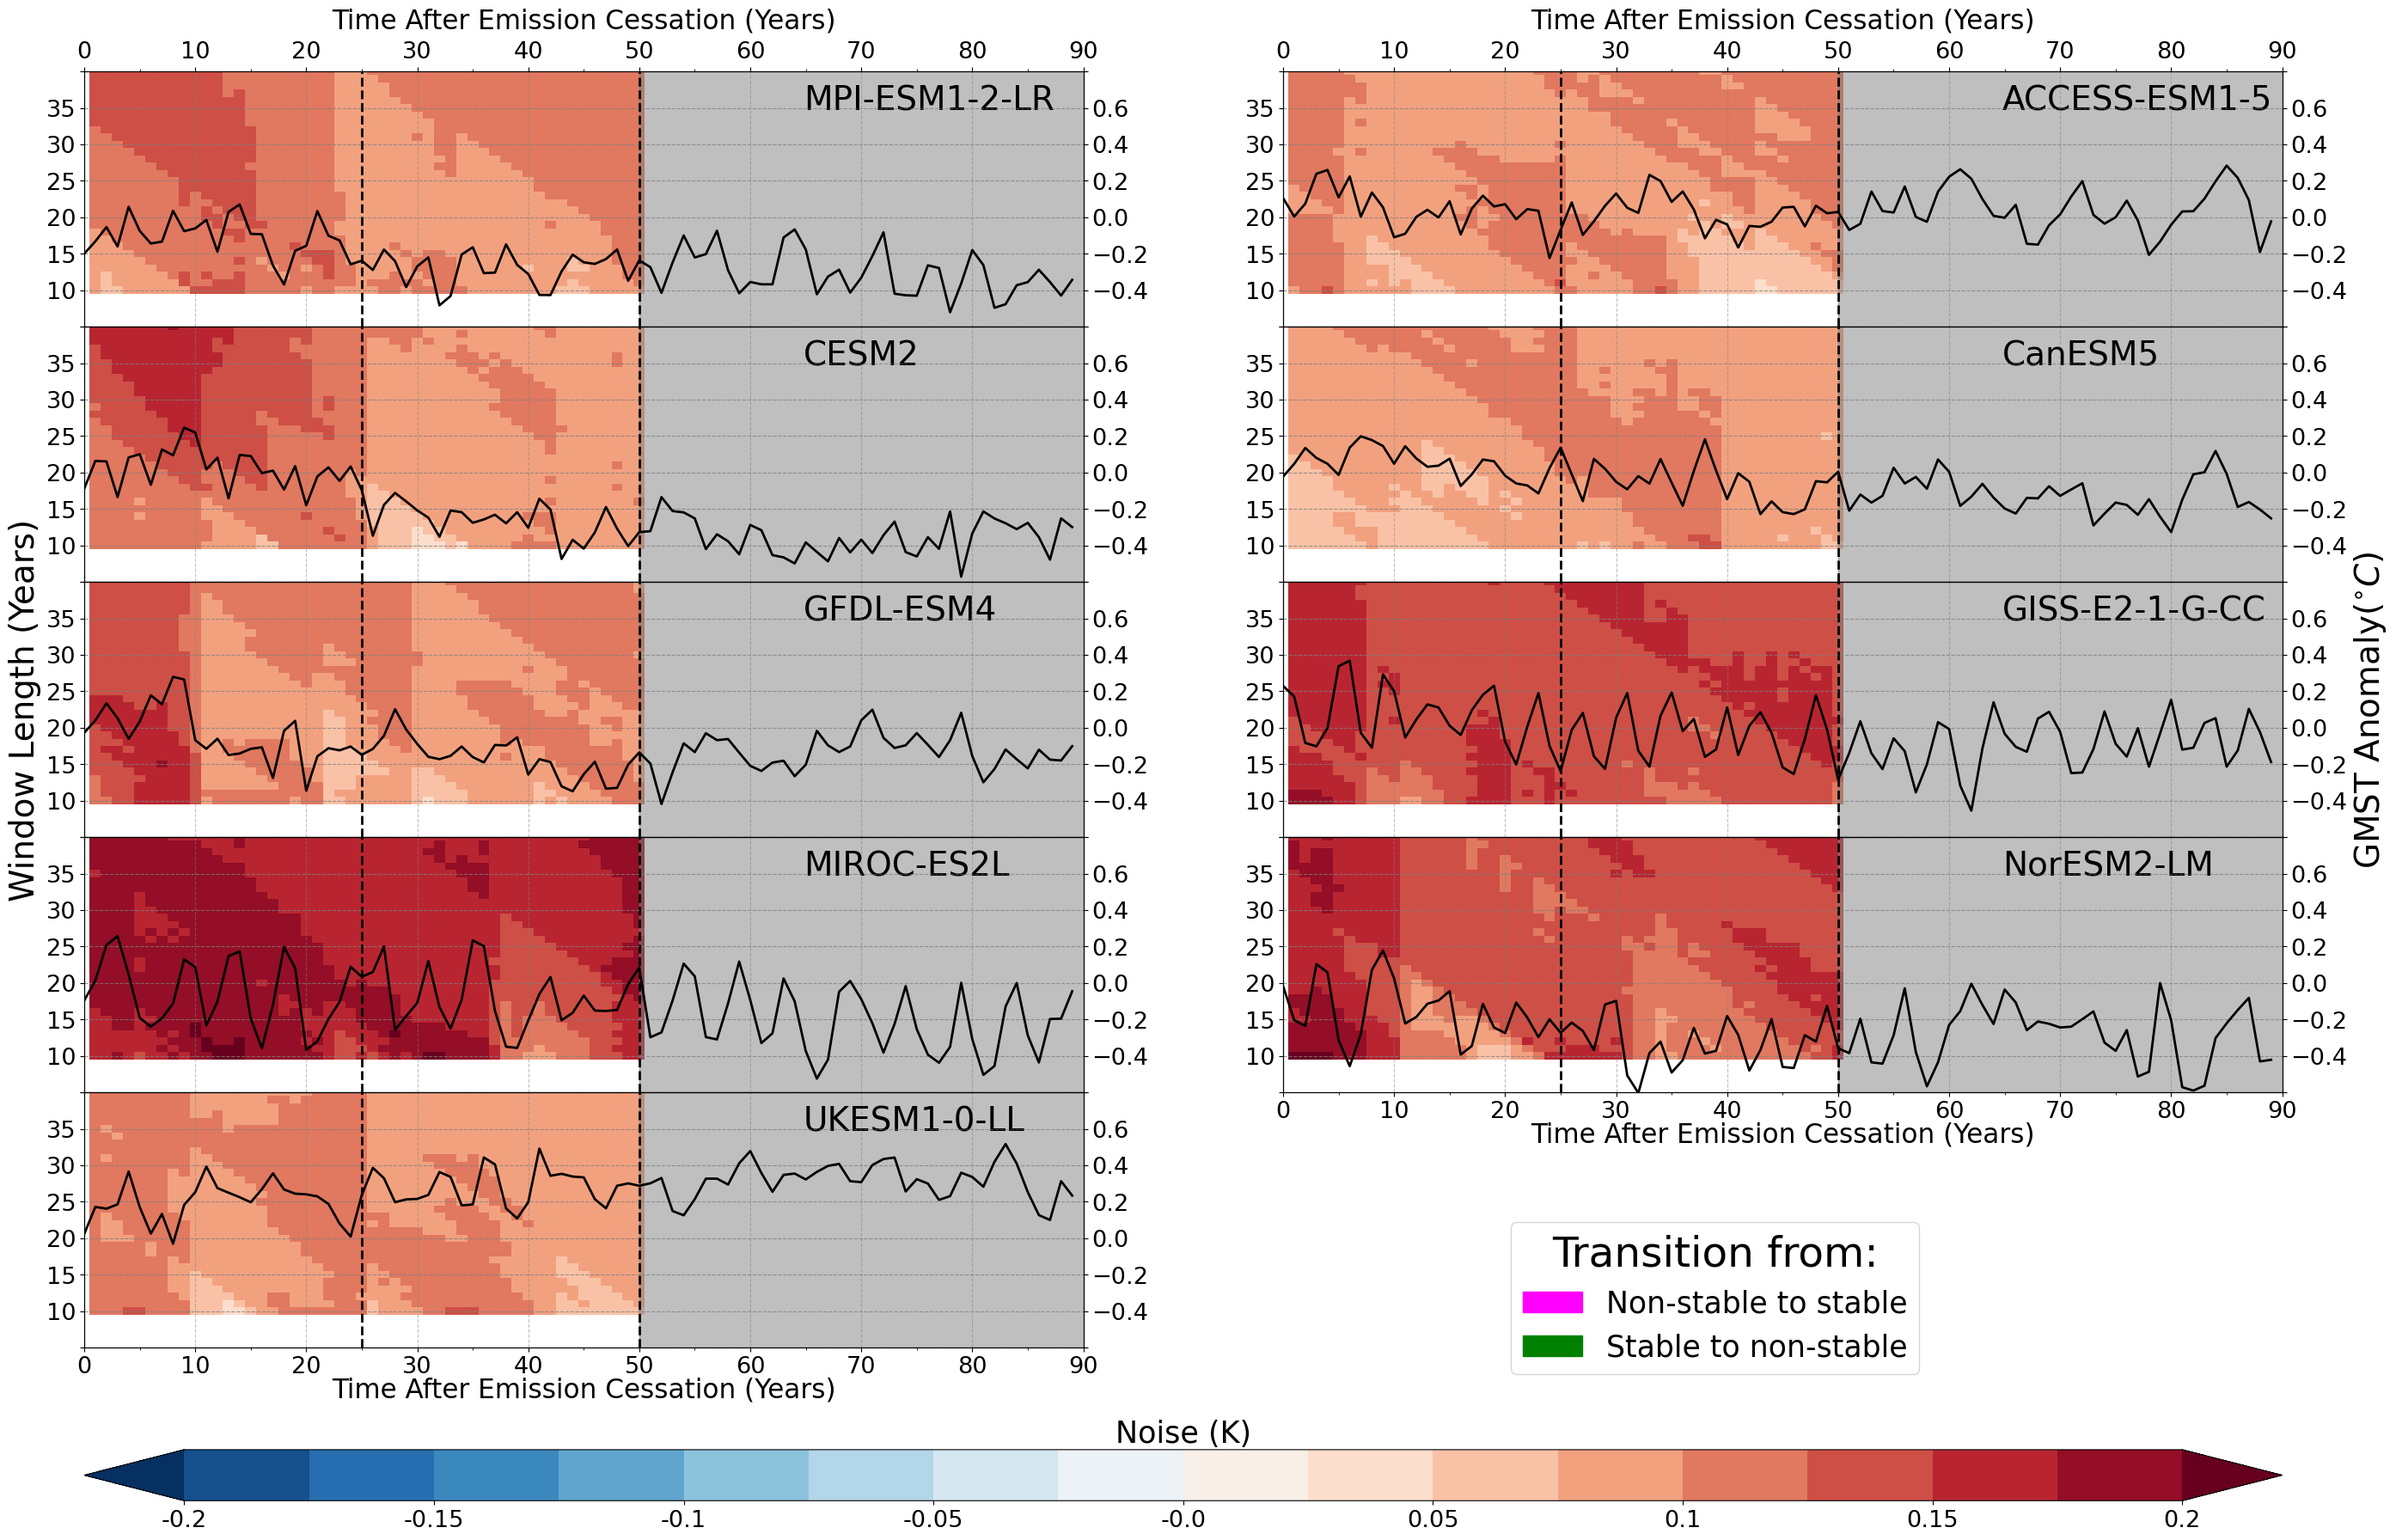

In [124]:
%matplotlib inline
models = unstable_rolling_ds.model.values
font_scale = 1.4

stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=True, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]

for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        noise_multi_rolling_da.sel(model=model).squeeze().isel(time=slice(0, 50)),
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        # stable_point_ds = rolling_year_stable_ds.sel(model=model),#rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **noise_colorplot_kwargs) 
    
    ax, ax2, cax = returned_axes
    
    # Lines at zec25 and zec50
    ax.axvline(25, 0, 1000, color='k', linewidth=2, linestyle='--')
    ax.axvline(50, 0, 1000, color='k', linewidth=2, linestyle='--')

    # for snum,year in enumerate(year_stable_and_unstable_static_ds.sel(model=model).values):
    #     ax.axvline(year, c=line_colors[snum%2], linewidth=2.5)

    ax.axvspan(50, 90, color='grey', alpha=0.5)

    
    plotting_functions.clip_axis_ends(ax)
    plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    ax2.set_ylabel('')
    if num  == 4: ax.set_ylabel('Window Length (Years)', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num  == 5: ax2.set_ylabel(f'GMST Anomaly({units})', size=plotting_functions.PlotConfig.title_size*font_scale)
    ax.annotate(model, xy=(0.72, 0.85), xycoords='axes fraction', ha='left', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num <= 1:
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    
    if 1 < num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')

magenta_patch = mpatches.Patch(color='magenta', label='Non-stable to stable')
green_patch = mpatches.Patch(color='green', label='Stable to non-stable')
leg = fig.legend(handles=[magenta_patch, green_patch], loc='lower center', ncol=1, fontsize=25, bbox_to_anchor=[0.7, 0.17])
leg.set_title('Transition from:', prop={'size': 35})

### Fig S10 (Segments from Pi-Control)

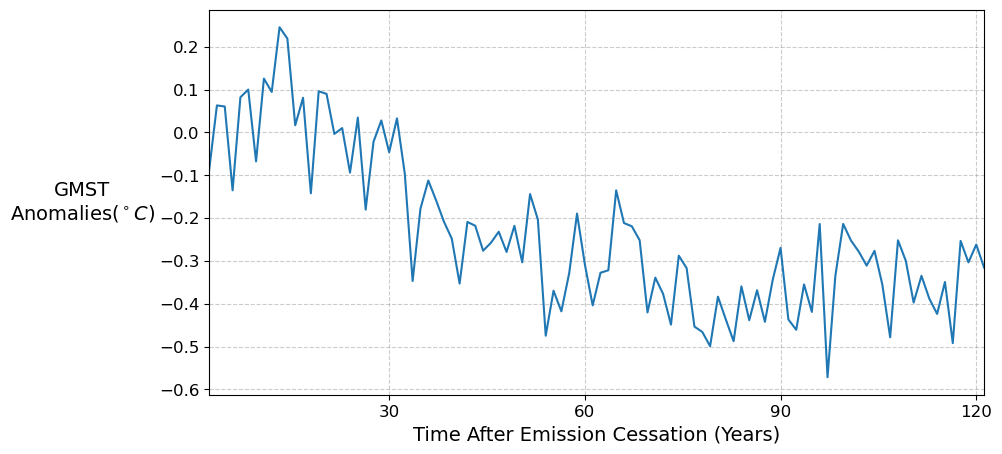

In [125]:
fig,ax1 = plt.subplots(1, 1,figsize=(10, 5))
# ax2 = ax.twinx()
ax1.plot(a1_smean_anom_ds.time.values, a1_smean_anom_ds.sel(model='CESM2').values)


# for window in [20, 40]:#np.arange(20, 41):
#     vals = a1_smean_anom_ds.sel(model='CESM2').isel(time=slice(0, window)).values
#     x = np.arange(len(vals))

#     grad_int = np.polyfit(x, vals, deg=1)
#     fitted_line = np.polyval(grad_int, x)
#     ax1.plot(a1_smean_anom_ds.time.values[:window], fitted_line, color='k', linewidth=2)


ax1.set_ylabel('GMST\nAnomalies' + r'($^\circ C$)', fontsize=14, rotation=0, labelpad=55, va='center', ha='center')

ax1.set_xticklabels([int(t.get_text()) for t in ax1.get_xticklabels()[1:]], size=12)
ax1.tick_params(axis='y', labelsize=12)
# sn_plotting.format_ticks_as_years(ax2, esmpi_smean_ds.sel(model='UKESM1-0-LL').isel(time=slice(650, 780)).time)
ax1.set_xlim(np.take(a1_smean_anom_ds.time.values, [0,-1]))
ax1.set_xlabel('Time After Emission Cessation (Years)', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.4, color='grey')

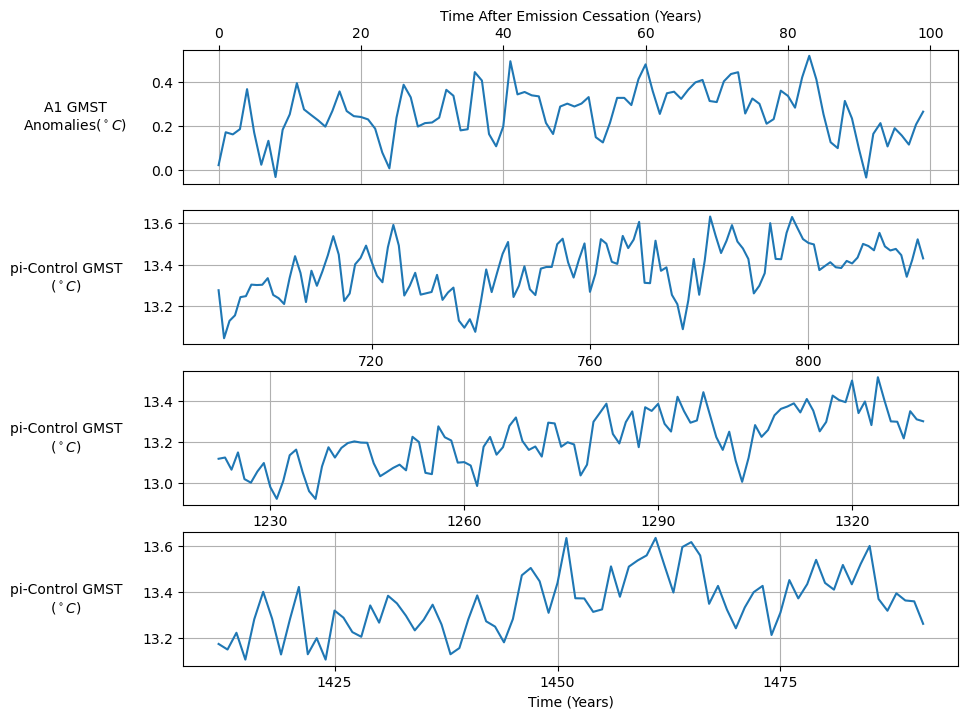

In [126]:
fig,(ax1, ax2, ax3, ax4) = plt.subplots(4, 1,figsize=(10, 8))
# ax2 = ax.twinx()
ax1.plot(a1_smean_anom_ds.sel(model='UKESM1-0-LL').values)
# ax2.plot(esmpi_smean_ds.sel(model='UKESM1-0-LL').isel(time=slice(650, 780)).values)
esmpi_smean_ds.sel(model='UKESM1-0-LL').isel(time=slice(650, 780)).plot(ax=ax2)
esmpi_smean_ds.isel(time=slice(1220, 1330)).sel(model='UKESM1-0-LL').plot(ax=ax3)
esmpi_smean_ds.sel(model='UKESM1-0-LL').isel(time=slice(1410, 1490)).plot(ax=ax4)

ax1.set_ylabel('A1 GMST\nAnomalies' + r'($^\circ C$)', rotation=0, labelpad=55, va='center', ha='center')
ax2.set_ylabel('pi-Control GMST\n' + r'($^\circ C$)', rotation=0, labelpad=55, va='center', ha='center')
ax3.set_ylabel('pi-Control GMST\n' + r'($^\circ C$)', rotation=0, labelpad=55, va='center', ha='center')
ax4.set_ylabel('pi-Control GMST\n' + r'($^\circ C$)', rotation=0, labelpad=55, va='center', ha='center')

ax2.set_xticklabels([int(t.get_text()) for t in ax2.get_xticklabels()[1:]])
# sn_plotting.format_ticks_as_years(ax2, esmpi_smean_ds.sel(model='UKESM1-0-LL').isel(time=slice(650, 780)).time)

ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
ax1.set_xlabel('Time After Emission Cessation (Years)')
ax4.set_xlabel('Time (Years)')

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_title('')
    ax.grid(True)

## Posters and Presentations

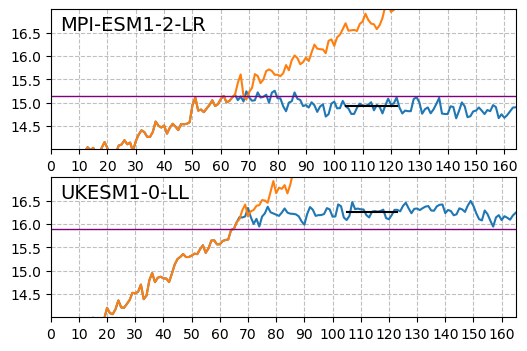

In [127]:
model_subset = ['MPI-ESM1-2-LR', 'UKESM1-0-LL']
ncols = 1
nrows = len(model_subset)

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(len(model_subset))]

for num, model in enumerate(model_subset):
    ds_orig = pct_smean_xrlist[model]
    ax = axes[num]
    ds = ds_orig.copy(deep=True)  # Create a deep copy to avoid modifying the original dataset
    ds2 = a1_smean_xrlist[model].copy(deep=True)
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    
    # Ensure that reset_time_to_0_start returns a new dataset
    ds = utils.reset_time_to_0_start(ds.copy(deep=True))
    ds_orig = utils.reset_time_to_0_start(ds_orig.copy(deep=True))  # Create a deep copy to avoid modifying the original dataset
    
    ds['time'] = ds.time.dt.year.values
    ds_orig['time'] = ds_orig.time.dt.year.values
    
    ds_base = ds_orig.isel(time=slice(start_arg-10, start_arg+9))

    # A1
    ax.plot(ds.time.values, ds.squeeze().values, label='A1')
    # 1% CO2
    ax.plot(ds_orig.time.values, ds_orig.squeeze().values, label='1% CO2')

    # Vertical Line marking start of A1
    # ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='A1 Branch Point')

    # Base period dashed line
    # ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period', linestyle='--', color='purple')
    
    # Line for the average of the base period
    ax.axhline(ds_base.mean(dim='time').values.item(), linewidth=1, color='purple', label='Base Period Average')
    
    #Dashed lines for ZEC25 and ZEC50
    ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    # ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC'+r'$_{25}$', linestyle='--')
    ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    ax.plot(ds_50.time.values, np.tile(ds_50.mean().values, len(ds_50.time.values)), color='black')
    # ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC'+r'$_{50}$', linestyle='--', color='black')

    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([14, 17])
    ax.set_yticks(np.arange(14.5, 17, 0.5))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)

    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    #if num not in [7, 8]: ax.set_xticklabels('')

# Place the legend at the center just above the first row of plots
# # Adjust the bbox_to_anchor values to center the legend
# leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
# axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)

## ProtoTypes

In [128]:
DO_NOT_RUN_PROTOTYPES

NameError: name 'DO_NOT_RUN_PROTOTYPES' is not defined

In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds) in enumerate(pct_smean_xrlist):
    ds2 = a1_smean_xrlist[model]
    ax = axes[num]
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.isel(time=slice(None, -1))
    ax.plot(ds.time.values, ds.squeeze().values, label='1% CO2')
    ax.plot(ds2.time.values, ds2.squeeze().values, label='A1')
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    llim = 0.95 * np.min([ds.min().values, ds2.min().values])
    ulim = 1.1 * np.max([ds.max().values, ds2.max().values])
    # llim=12; ulim=18
    ax.set_ylim([llim, ulim])
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    if num%2: ax.set_yticklabels([])
    ax.axhline([0], zorder=-10, color='grey', alpha=0.5, linestyle='--')
    sn_plotting.format_xticks(ax, np.concatenate([ds.time.values, ds2.time.values]), 
                              np.concatenate([ds.time.dt.year.values, ds2.time.dt.year.values])-1)
    ax.xaxis.grid(True, alpha=0.5, c='grey', linestyle='--')
    ax.axvline(ds2.time.values[0], llim, ulim, color='red')


axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(models):
    ds = a1_smean_anom_ds.sel(model=model).squeeze()
    ax = axes[num]
    ax.plot(ds.time.values, ds.values, label=model)
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([-0.6, 0.6])
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    if num%2: ax.set_yticklabels([])
    ax.axhline([0], zorder=-10, color='grey', alpha=0.5, linestyle='--')
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.dt.year.values-1)
    ax.xaxis.grid(True, alpha=0.5, c='grey', linestyle='--')

axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
fig = plt.figure(figsize=(8, 15))
gs = gridspec.GridSpec(9, 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(a1_smean_anom_ds.model.values):
    ds = a1_smean_anom_ds.sel(model=model).squeeze()
    ax = axes[num]
    ax.plot(ds.time.values, ds.values, label=model)
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([-0.6, 0.6])
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.dt.year.values-1)
    #ax.axhline([0], zorder=-10, color='grey', alpha=0.3, linestyle='--')
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')

ax.set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds) in enumerate(pct_smean_xrlist):
    ax = axes[num]
    ds2 = a1_smean_xrlist[model]
    # ax.plot(ds.time.values, ds.squeeze().values)
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    ds = utils.reset_time_to_0_start(ds)
    ds['time'] = ds.time.dt.year.values
    
    ax.plot(ds.time.values, ds.squeeze().values) #label='1% CO2')
    ds_base = ds.isel(time=slice(start_arg-10, start_arg+9))
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period')

    # ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    # ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC25 Period')
    
    
    # ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    # ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC50 Period')
    
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([12, 18])
    ax.set_yticks(np.arange(13, 18, 1))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    #if num%2: ax.set_yticklabels([])
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)
    ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='Abrupt Zero CO2 Emissions Point')
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    #if num not in [7, 8]: ax.set_xticklabels('')

leg = axes[0].legend(ncol=4, bbox_to_anchor=[2.1, 1.4], fontsize=12)
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
ncols = 1
models = pct_smean_xrlist.refkeys
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds_orig) in enumerate(pct_smean_xrlist):
    ax = axes[num]
    ds = ds_orig.copy(deep=True)  # Create a deep copy to avoid modifying the original dataset
    ds2 = a1_smean_xrlist[model].copy(deep=True)
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    
    # Ensure that reset_time_to_0_start returns a new dataset
    ds = utils.reset_time_to_0_start(ds.copy(deep=True))
    ds_orig = utils.reset_time_to_0_start(ds_orig.copy(deep=True))  # Create a deep copy to avoid modifying the original dataset
    
    ds['time'] = ds.time.dt.year.values
    ds_orig['time'] = ds_orig.time.dt.year.values
    
    
    ax.plot(ds.time.values, ds.squeeze().values, label='A1')
    ax.plot(ds_orig.time.values, ds_orig.squeeze().values, label='1% CO2')
    
    ds_base = ds_orig.isel(time=slice(start_arg-10, start_arg+9))
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period', linestyle='--')

    ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC25', linestyle='--')
    
    ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC50', linestyle='--')
    
    
    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([14, 17])
    ax.set_yticks(np.arange(14.5, 17, 0.5))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    #if num%2: ax.set_yticklabels([])
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)
    ax.axvline(ds.time.values[start_arg], linewidth=1, color='black')#, label='A1')
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    if num not in [8]: ax.set_xticklabels('')

leg = axes[0].legend(ncol=2, bbox_to_anchor=[0.76, 1.6], fontsize=12)
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)

### Old PCT A1 Plots

In [ ]:
def plot_model_data(ax, model, ds_pct, ds_a1_copy):
    """
    Plots model data for temperature anomalies comparing 1% CO2 and A1 experiment data.

    Parameters:
    ax : matplotlib.axes.Axes
        The axis to plot on.
    model : str
        The name of the model being plotted.
    ds_pct : xarray.Dataset
        The dataset containing 1% CO2 experiment data.
    ds_a1_copy : xarray.Dataset
        The dataset containing A1 experiment data.
    """
    
    # Create deep copies to avoid modifying the original datasets
    ds_pct_copy = ds_pct.copy(deep=True)
    ds_a1_copy = ds_a1_copy.copy(deep=True)
    
    # Align ds_pct_copy to start at the same time as ds_a1_copy
    ds_pct_copy = ds_pct_copy.sel(time=slice(None, ds_a1_copy.time.values[0]))
    
    # Combine the last time step of ds_pct_copy with ds_a1_copy to ensure continuity
    ds_a1_copy = ds_a1_copy.combine_first(ds_pct_copy.isel(time=slice(-2, -1)))
    
    # Merge ds_pct_copy and ds_a1_copy
    ds_pct_copy = ds_pct_copy.combine_first(ds_a1_copy)
    
    # Find the index of the first time step of ds_a1_copy in ds_pct_copy
    start_arg = np.argwhere(ds_pct_copy.time.values == ds_a1_copy.time.values[0]).item()
    
    # Reset the time coordinate of both datasets to start from 0
    ds_pct_copy = utils.reset_time_to_0_start(ds_pct_copy.copy(deep=True))
    ds_pct = utils.reset_time_to_0_start(ds_pct.copy(deep=True))
    
    # Convert time coordinates from datetime to year values
    ds_pct_copy['time'] = ds_pct_copy.time.dt.year.values
    ds_pct['time'] = ds_pct.time.dt.year.values
    
    # Select a 20-year base period centered around the start_arg in ds_pct
    ds_base = ds_pct.isel(time=slice(start_arg-10, start_arg+9))
    
    # Plot the A1 experiment data
    ax.plot(ds_pct_copy.time.values, ds_pct_copy.squeeze().values, label='A1')
    
    # Plot the 1% CO2 experiment data
    ax.plot(ds_pct.time.values, ds_pct.squeeze().values, label='1% CO2')
    
    # Vertical line marking the start of the A1 experiment
    ax.axvline(ds_pct_copy.time.values[start_arg], linewidth=1, color='black', label='A1 Branch Point')
    
    # Dashed line for the base period
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period', linestyle='--', color='purple')
    
    # Horizontal line for the average value of the base period
    ax.axhline(ds_base.mean(dim='time').values.item(), linewidth=1, color='purple', label='Base Period Average')
    
    # Plot ZEC25 (25 years after start) with a dashed line
    ds_25 = ds_pct_copy.isel(time=slice(start_arg+25-10, start_arg+25+9))
    ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC'+r'$_{25}$', linestyle='--')
    
    # Plot ZEC50 (50 years after start) with a dashed line in black
    ds_50 = ds_pct_copy.isel(time=slice(start_arg+50-10, start_arg+50+9))
    ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC'+r'$_{50}$', linestyle='--', color='black')

    # Annotate the plot with the model name
    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    
    # Set y-axis limits and ticks
    ax.set_ylim([14, 17])
    ax.set_yticks(np.arange(14.5, 17, 0.5))
    
    # Set x-axis limits based on the time range in ds_pct_copy
    ax.set_xlim(np.take(ds_pct_copy.time.values, [0, -1]))
    
    # Add a grid to the plot with specified styling
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')

    # Format x-axis ticks
    sn_plotting.format_xticks(ax, ds_pct.time.values, ds_pct.time.values-1)

ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

# Iterate over the models and plot each one using plot_model_data
for num, (model, ds_pct) in enumerate(pct_smean_xrlist):
    plot_model_data(axes[num], model, ds_pct, a1_smean_xrlist[model])
    
    # Add y-axis label to the middle left subplot
    if num == int(len(models)/2)-1:
        axes[num].set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    


# Place the legend above the first row of plots
leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)

# Add x-axis label to the last subplot
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)


In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds_orig) in enumerate(pct_smean_xrlist):
    ax = axes[num]
    ds = ds_orig.copy(deep=True)  # Create a deep copy to avoid modifying the original dataset
    ds2 = a1_smean_xrlist[model].copy(deep=True)
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    
    # Ensure that reset_time_to_0_start returns a new dataset
    ds = utils.reset_time_to_0_start(ds.copy(deep=True))
    ds_orig = utils.reset_time_to_0_start(ds_orig.copy(deep=True))  # Create a deep copy to avoid modifying the original dataset
    
    ds['time'] = ds.time.dt.year.values
    ds_orig['time'] = ds_orig.time.dt.year.values
    
    ds_base = ds_orig.isel(time=slice(start_arg-10, start_arg+9))

    # A1
    ax.plot(ds.time.values, ds.squeeze().values, label='A1')
    # 1% CO2
    ax.plot(ds_orig.time.values, ds_orig.squeeze().values, label='1% CO2')

    # Vertical Line marking start of A1
    ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='A1 Branch Point')

    # Base period dashed line
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period', linestyle='--', color='purple')
    
    # Line for the average of the base period
    ax.axhline(ds_base.mean(dim='time').values.item(), linewidth=1, color='purple', label='Base Period Average')
    
    #Dashed lines for ZEC25 and ZEC50
    ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC'+r'$_{25}$', linestyle='--')
    ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    # ax.plot(ds_50.time.values, np.tile(ds_50.mean().values, len(ds_50.time.values)), color='black')
    ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC'+r'$_{50}$', linestyle='--', color='black')

    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([14, 17])
    ax.set_yticks(np.arange(14.5, 17, 0.5))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)

    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    #if num not in [7, 8]: ax.set_xticklabels('')

# Place the legend at the center just above the first row of plots
# Adjust the bbox_to_anchor values to center the legend
leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)

In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(7*ncols, 3*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=.2)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds_orig) in enumerate(pct_smean_xrlist):
    ax = axes[num]
    ds = ds_orig.copy(deep=True)  # Create a deep copy to avoid modifying the original dataset
    ds2 = a1_smean_xrlist[model].copy(deep=True)
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    
    # Ensure that reset_time_to_0_start returns a new dataset
    ds = utils.reset_time_to_0_start(ds.copy(deep=True))
    ds_orig = utils.reset_time_to_0_start(ds_orig.copy(deep=True))  # Create a deep copy to avoid modifying the original dataset
    
    ds['time'] = ds.time.dt.year.values
    ds_orig['time'] = ds_orig.time.dt.year.values
    
    ds_base = ds_orig.isel(time=slice(start_arg-10, start_arg+9))

    # A1
    ax.plot(ds.time.values, ds.squeeze().values, label='A1')
    # 1% CO2
    ax.plot(ds_orig.time.values, ds_orig.squeeze().values, label='1% CO2')

    # Vertical Line marking start of A1
    ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='A1 Branch Point')

    # Base period dashed line
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period', linestyle='--', color='purple')
    
    # Line for the average of the base period
    ax.axhline(ds_base.mean(dim='time').values.item(), linewidth=1, color='purple', label='Base Period Average')
    
    #Dashed lines for ZEC25 and ZEC50
    # ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    # ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC'+r'$_{25}$', linestyle='--')
    ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC'+r'$_{50}$', linestyle='--', color='black')

    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([14, 17])
    ax.set_yticks(np.arange(14.5, 17, 0.5))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    ax.set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)

    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    #if num not in [7, 8]: ax.set_xticklabels('')

# Place the legend at the center just above the first row of plots
# Adjust the bbox_to_anchor values to center the legend
leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)

In [ ]:
%matplotlib inline
models = unstable_rolling_ds.model.values

num_plots = len(models)

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*0.7,  20))
gs = gridspec.GridSpec(num_plots+1, 2, height_ratios=num_plots*[1] + [0.2],
                       width_ratios=[1, 0.2], hspace=sn_plotting.plot_kwargs['hspace']*1.1)

axes_left = [fig.add_subplot(gs[i, 0]) for i in range(num_plots)]
axes_right = [fig.add_subplot(gs[i, 1]) for i in range(num_plots)]
for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num+1, :])
    
    sn_plotting.sn_multi_window_in_time(
        unstable_rolling_ds.sel(model=model).squeeze().signal_to_noise,
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        stable_point_ds = rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes_left[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title=model, yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs)  
    
    # Lower and upper bound plots
    sn_multi_rolling_ds.sel(model=model).upper_bound.plot(ax=axes_right[num], y='window', color='red', label='Upper Bound')
    sn_multi_rolling_ds.sel(model=model).lower_bound.plot(ax=axes_right[num], y='window', color='blue',label='Lower Bound')
    plotting_functions.format_axis(axes_right[num], xlabel='Signal-to-Noise Ratio', ylabel='',title='', font_scale=1.2)
    format_null_axis(axes_right[num])
    if num == len(models)-1:axes_right[num].legend(ncol=1, fontsize=18)
# axes = axes_left.extend(axes_right)
# for num, ax in enumerate(axes): plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=1.4)

In [ ]:
stability_colorplot_kwargs_no_temp_line = dict(max_color_lim=max_effective_length, xlims=(0, max_effective_length),patch=False,
                                               ax2_ylabel=f'GMST Anomaly({units})', labelpad_left=70)

In [ ]:
plot_kwargs = {'exp_type': 'zecmip','levels': np.arange(0, 11, 1), 'tick_offset': 'center',
               'extend': 'neither', 'cbar_label': 'Number of Models not in Equilibrium'}

In [ ]:
my_blues = plotting_functions.create_discrete_cmap('BuPu', levels=plot_kwargs['levels'], add_white=True)

In [ ]:
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], sn_plotting.plot_kwargs['height']*2.1))

gs = gridspec.GridSpec(3,1, height_ratios=[1, 1, 0.1], hspace=sn_plotting.plot_kwargs['hspace'])
axes = [fig.add_subplot(gs[i]) for i in range(3)]

sn_plotting.sn_multi_window_in_time(
    decreasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False,
    axes_title='Decreasing Temperature Trends', bbox_to_anchor=(1, 1.4),
    **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

sn_plotting.sn_multi_window_in_time(
    increasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False,
    axes_title='Increasing Temperature Trends',
    add_legend=False, **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

for num, ax_ in enumerate(axes[:2]): plotting_functions.add_figure_label(ax_, f'{chr(97+num)})')

In [ ]:
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], sn_plotting.plot_kwargs['height']*1.6))

gs = gridspec.GridSpec(4,1, height_ratios=[1, 1, 0.2, 0.1], hspace=0)
axes = [fig.add_subplot(gs[i]) for i in [0, 1, 3]]

sn_plotting.sn_multi_window_in_time(
    decreasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False,
    axes_title='',#'Decreasing Temperature Trends',
    ylabel='',
    bbox_to_anchor=(1, 1.4),
    **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

sn_plotting.sn_multi_window_in_time(
    increasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False,
    axes_title='', ylabel='', #'Increasing Temperature Trends',
    add_legend=False, **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

for ax in axes[:2]:
    ax.axvline(increasing_ds.time.dt.year.values[24], 0, 1000, color='k', linewidth=5, linestyle=':')
    ax.axvline(increasing_ds.time.dt.year.values[49], 0, 1000, color='k', linewidth=5, linestyle=':')
axes[0].set_ylabel(''); axes[1].set_ylabel('')
axes[1].annotate('Window Lenght (years)', xy=(-.06, 0.7), size=35, xycoords='axes fraction', clip_on=False, rotation=90)
# for num, ax_ in enumerate(axes[:2]): plotting_functions.add_figure_label(ax_, f'{chr(97+num)})')
axes[0].set_xticklabels([]);

In [ ]:
#### Rolling VS Static Noise

%matplotlib inline
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], sn_plotting.plot_kwargs['height']*2.1))

gs = gridspec.GridSpec(3,1, height_ratios=[1, 1, 0.1], hspace=sn_plotting.plot_kwargs['hspace'])
axes = [fig.add_subplot(gs[i]) for i in range(3)]

sn_plotting.sn_multi_window_in_time(
    rolling_stability_levels_ds.sel(stability='increasing').count(dim='model')+\
    rolling_stability_levels_ds.sel(stability='decreasing').count(dim='model'),
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False,
    axes_title='Rolling Noise', bbox_to_anchor=(1, 1.4),
    **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

sn_plotting.sn_multi_window_in_time(
    static_stability_levels_ds.sel(stability='increasing').count(dim='model')+\
    static_stability_levels_ds.sel(stability='decreasing').count(dim='model')
    , cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False,
    axes_title='Static Noise',
    add_legend=False, **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

for num, ax_ in enumerate(axes[:2]): plotting_functions.add_figure_label(ax_, f'{chr(97+num)})')

In [ ]:
# Noise Median
noise_levels = sn_plotting.create_levels(vmax=.2, vmin=0, step=.01)
sn_plotting.plot_heatmap(noise_multi_rolling_da.median(dim='model'), levels=noise_levels, 
                                figsize=(sn_plotting.plot_kwargs['width']/3,
                                         sn_plotting.plot_kwargs['height']/2), 
                               cmap='BuPu', extend='max', cut_ticks=2, max_color_lim=50, 
                               font_scale=0.8, cbar_label='Noise', hspace=0.2, return_all=False)

In [ ]:
%matplotlib inline
models = unstable_rolling_ds.model.values
font_scale = 0.7

num_plots = len(models)
num_cols = 1
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(10,  21))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.2]+[0.2],hspace=0.2, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]

for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        unstable_rolling_ds.sel(model=model).squeeze().signal_to_noise,
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        stable_point_ds = rolling_year_stable_ds.sel(model=model),#rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs_2) 
    ax, ax2, cax = returned_axes
    ax.axvline(unstable_rolling_ds.time.values[24], 0, 1000, color='k', linewidth=2, linestyle='--')
    ax.axvline(unstable_rolling_ds.time.values[49], 0, 1000, color='k', linewidth=2, linestyle='--')
    #ax.set_ylim(9, 40)


    plotting_functions.clip_axis_ends(ax)
    plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    if num == 4: ax.set_ylabel('Window Length (years)', size=12)
    if num == 4: ax2.set_ylabel(f'GMST Anomaly({units})', size=12)
    ax.annotate(model, xy=(0.75, 0.85), xycoords='axes fraction', ha='left', size=16)
    if num < 9:
        ax.set_xlabel('')
    


In [ ]:
# %matplotlib inline
models = a1_smean_anom_ds.model.values
font_scale = 1.4

stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=True, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]

for num, model in enumerate(models):
    

    ax = axes[num]
    ax.plot(a1_smean_anom_ds.time.dt.year.values, a1_smean_anom_ds.sel(model=model).values)
    # a1_smean_anom_ds.squeeze().sel(model=model).plot(ax=ax)

    
    
#     ax.axvline(a1_smean_anom_ds.time.values[24], 0, 1000, color='k', linewidth=2, linestyle='--')
#     ax.axvline(a1_smean_anom_ds.time.values[49], 0, 1000, color='k', linewidth=2, linestyle='--')
    year_of_stabilisation_model =  year_of_stabilisation_df.loc[model].year
    y_scatter = year_of_stabilisation_df.loc[model].temp
    ax.axvline(year_of_stabilisation_model, 0, 1000, color='fuchsia', linewidth=2, linestyle='-')
    
    ax.set_xlim(*np.take(a1_smean_anom_ds.time.dt.year.values, [0, -1]))
    ax.set_ylabel('')
    if num  in [4, 5]: ax.set_ylabel(f'GMST Anomaly({units})', size=plotting_functions.PlotConfig.title_size*font_scale)
    ax.annotate(model, xy=(0.72, 0.85), xycoords='axes fraction', ha='left', 
                size=plotting_functions.PlotConfig.title_size*font_scale)
    if num <= 1:
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    
    
    if 1 < num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')
    else:
        ax.tick_params(axis='x', labelsize=24)

    ax.grid(True, linestyle='--', alpha=0.5, color='grey')
    ax.tick_params(axis='y', labelsize=24)


### Period of neither stable or unstable

In [ ]:
sn_multi_rolling_ds.lower_bound.plot(hue='model', y='window');

In [ ]:
sn_multi_rolling_ds.upper_bound.plot(hue='model', y='window');

In [ ]:
# stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=True, ax2_ylabel=f'GMST Anomaly({units})',
#                                   cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
#                                   cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise\nRatio', hspace=0.2,
#                                   return_all=True, rotation=90)
sn_levels = np.arange(-4.5, 4.5+.5, 0.5)
stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=True, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

In [ ]:
tds = rolling_year_stable_ds.isel(model=0).squeeze()
tds2 = rolling_year_stable_ds_plus_window.isel(model=0).squeeze()

plt.plot(tds.time.values, tds.window.values)

plt.plot(tds2.time.values, tds2.window.values)
plt.fill_betweenx(tds.window.values, tds.time.values, tds2.time.values,
                  color='grey', alpha=0.2, hatch='x')

In [ ]:
%matplotlib inline
models = unstable_rolling_ds.model.values

num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]
font_scale = 1.4
for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    #ax.set_ylim(8, 41)
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        unstable_rolling_ds.sel(model=model).squeeze().signal_to_noise,
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        #stable_point_ds = rolling_year_stable_ds_plus_window.sel(model=model),#rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs) 
    ax, ax2, cax = returned_axes
    ax.axvline(unstable_rolling_ds.time.values[24], 0, 1000, color='k', linewidth=2, linestyle='--')
    ax.axvline(unstable_rolling_ds.time.values[49], 0, 1000, color='k', linewidth=2, linestyle='--')
    

    # Adding the stabilisation year and theb fill between
    tds = rolling_year_stable_ds.sel(model=model).squeeze()
    tds2 = rolling_year_stable_ds_plus_window.sel(model=model).squeeze()
    
    ax.plot(tds.time.values, tds.window.values, color='green')
    ax.plot(tds2.time.values, tds2.window.values, color='purple')
    
    ax.fill_betweenx(tds.window.values, tds.time.values, tds2.time.values,
                      color='grey', alpha=0.2, hatch='x')
    
    # rolling_year_stable_ds_plus_window.time.sel(model=model).plot(ax=ax, y='window')
    # rolling_year_stable_ds.time.sel(model=model).plot(ax=ax, y='window')
    if (num+1)%2: # Left plot
        ax2.set_yticks([])
        ax2.set_yticklabels([])
        plotting_functions.clip_axis_ends(ax)
    else: # Right plot
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_ylabel(' ')
        plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    if num  == 4: ax.set_ylabel('Window Length (years)',
                                size=plotting_functions.PlotConfig.title_size*font_scale)
    if num  == 5: ax2.set_ylabel(f'GMST Anomaly({units})', 
                                 size=plotting_functions.PlotConfig.title_size*font_scale)
    ax.annotate(model, xy=(0.75, 0.85), xycoords='axes fraction', ha='left', 
                size=plotting_functions.PlotConfig.title_size*font_scale)
    
    if num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')

### Number Stable at Each Time Step

In [ ]:
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111)

# ds1_mean = static_year_stable_ds.median(dim='model')
# ds2_mean = rolling_year_stable_ds.median(dim='model')
# ds1_mean.plot(ax=ax, y='window', label='rolling', color='k', linewidth=1.5, linestyle='solid') 
# ds2_mean.plot(ax=ax,y='window', label='static', color='k', linewidth=1.5, linestyle='dashed') 

# ylims = np.take(ds1_mean.window.values, [0,-1])
# all_x_values = np.concatenate([ds1_mean.time.values, ds2_mean.time.values]).flatten()
# xlims = [np.min(all_x_values), np.max(all_x_values)]
# ax.set_xlim(xlims)
# ax.set_ylim(ylims)

# leg = ax.legend(ncol=1, loc='best', frameon=True, facecolor='white', fontsize=14) 
# leg.set_title('Noise Type')
# leg.get_title().set_fontsize('16')

# plotting_functions.format_axis(ax, xlabel=xlabel, ylabel=ylabel,font_scale=font_scale,
#                                invisible_spines=['top', 'right'])
# ax.set_title('')

In [ ]:
# fig, ax = sn_plotting.plot_average_stable_year(static_year_stable_ds, rolling_year_stable_ds, 
#                                                xlabel='Time After Emission Cessation (Years)')

### Year of each model stabilisation at each window

In [ ]:
plt.style.use('default')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

for num, model in enumerate(zec50_dict):
    color = zec50_dict[model]['color']
    linestyle = '-' if not num%2 else '--'#zec50_dict[model]['linestyle'] if 'linestyle' in zec50_dict[model] else '-'
    rolling_year_stable_ds.sel(model=model).time.plot(ax=ax, y='window', linewidth=2.5, alpha=0.8, color=color, label=model, linestyle=linestyle)
        
rolling_year_stable_ds.time.mean(dim='model').plot(ax=ax, y='window', linewidth=3, alpha=0.8, color='k', label='Mean')     
leg = ax.legend()
leg.set_title('Model')
leg.get_title().set_fontsize(plotting_functions.PlotConfig.legend_title_size)
plotting_functions.format_axis(ax, xlabel='Time after Emission Cessation (Years)', ylabel='Window Length\n(Years)', invisible_spines=['top', 'right'])
ax.set_ylim([10, 40])
ax.set_title('')